# Source: UCI Machine Learning Repository
- Thème: Prédiction d'abandon scolaire et réussite académique
- Établissement: Enseignement supérieur au Portugal
- URL: https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

In [1]:
import warnings
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    classification_report,
    confusion_matrix,
    f1_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from tools import (
    BINARY_TARGET_COLORS,
    BINARY_TARGET_ORDER,
    TERNARY_TARGET_COLORS,
    barh_metric,
    count_outliers_iqr,
    prepare_feature_engineering,
    print_dataset_summary,
)
from xgboost import XGBClassifier


warnings.filterwarnings("ignore")
sns.set_palette("Set2")

df = pd.read_csv("../data/dataset.csv", delimiter=";")

## Taille du dataset

In [2]:
print(f"Nombre d'observations: {df.shape[0]:,}")
print(f"Nombre de variables: {df.shape[1]}")

Nombre d'observations: 4,424
Nombre de variables: 37


## Liste des variables

In [3]:
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

 1. Marital status
 2. Application mode
 3. Application order
 4. Course
 5. Daytime/evening attendance	
 6. Previous qualification
 7. Previous qualification (grade)
 8. Nacionality
 9. Mother's qualification
10. Father's qualification
11. Mother's occupation
12. Father's occupation
13. Admission grade
14. Displaced
15. Educational special needs
16. Debtor
17. Tuition fees up to date
18. Gender
19. Scholarship holder
20. Age at enrollment
21. International
22. Curricular units 1st sem (credited)
23. Curricular units 1st sem (enrolled)
24. Curricular units 1st sem (evaluations)
25. Curricular units 1st sem (approved)
26. Curricular units 1st sem (grade)
27. Curricular units 1st sem (without evaluations)
28. Curricular units 2nd sem (credited)
29. Curricular units 2nd sem (enrolled)
30. Curricular units 2nd sem (evaluations)
31. Curricular units 2nd sem (approved)
32. Curricular units 2nd sem (grade)
33. Curricular units 2nd sem (without evaluations)
34. Unemployment rate
35. Inflation 

## Typage des données

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

## Description du dataset

In [5]:
df.describe()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


## Distribution de la variable cible (Target)

In [6]:
target_counts = df["Target"].value_counts()

result = (
    df["Target"]
    .value_counts()
    .to_frame(name="count")
    .assign(percentage=lambda x: x["count"] / x["count"].sum())
)
display(result)

,count,percentage
Target,,
Graduate,2209,0.499322
Dropout,1421,0.321203
Enrolled,794,0.179476


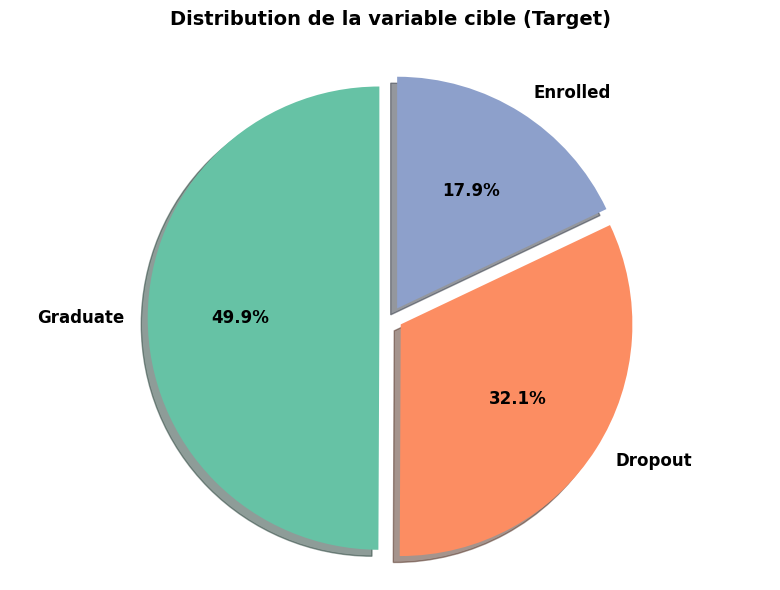

In [7]:
plt.figure(figsize=(8, 6))

explode = (0.05, 0.05, 0.05)  # Légère séparation des parts

plt.pie(
    target_counts.values,
    labels=target_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=TERNARY_TARGET_COLORS,
    explode=explode,
    shadow=True,
    textprops={"fontsize": 12, "weight": "bold"},
)

plt.title("Distribution de la variable cible (Target)", fontsize=14, weight="bold", pad=20)

plt.axis("equal")  # Pour avoir un cercle parfait
plt.tight_layout()
plt.show()

## Premieres lignes

In [8]:
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


### Nombre d'étudiants

In [9]:
len(df)

4424

## Classification Binaire: Dropout vs Non-Dropout
--> Non-Dropout = Enrolled + Graduate

In [10]:
# Créer une nouvelle variable binaire
df["Dropout_Binary"] = df["Target"].apply(lambda x: "Dropout" if x == "Dropout" else "Non-Dropout")

# Calculer les proportions
binary_counts = df["Dropout_Binary"].value_counts()
binary_pct = df["Dropout_Binary"].value_counts(normalize=True)

result = (
    df["Dropout_Binary"]
    .value_counts()
    .to_frame(name="count")
    .assign(percentage=lambda x: x["count"] / x["count"].sum())
)

display(result)

,count,percentage
Dropout_Binary,,
Non-Dropout,3003,0.678797
Dropout,1421,0.321203


### Composition de 'Non-Dropout'

In [11]:
non_dropout_detail = df[df["Dropout_Binary"] == "Non-Dropout"]["Target"]
result = (
    non_dropout_detail.value_counts()
    .to_frame(name="count")
    .assign(percentage=lambda x: x["count"] / x["count"].sum())
)
display(result)

,count,percentage
Target,,
Graduate,2209,0.735598
Enrolled,794,0.264402


## Comparaison d'une classification binaire vs ternaire

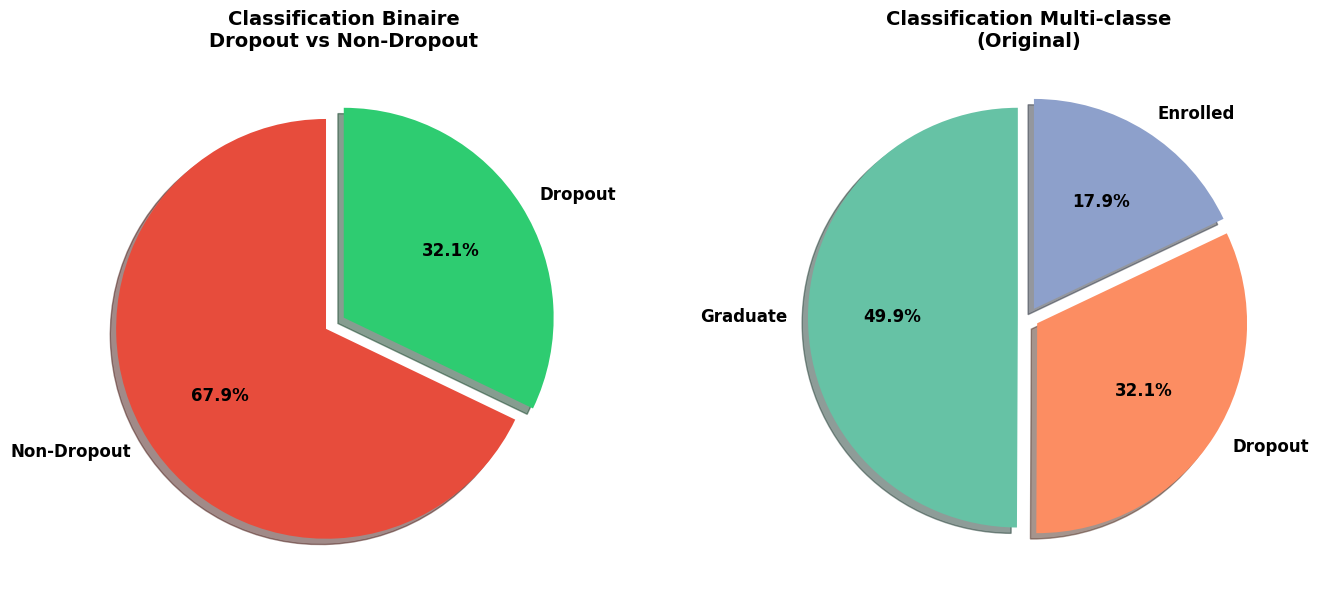


Comparaison:
- Approche binaire: 32.12% Dropout vs 67.88% Non-Dropout
- Ratio de déséquilibre: 1:2.11


In [12]:
# Visualisation: Dropout vs Non-Dropout avec pie chart
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Graphique 1: Distribution binaire
colors_binary = ["#e74c3c", "#2ecc71"]  # Rouge pour Dropout, Vert pour Non-Dropout
explode_binary = (0.1, 0)  # Faire ressortir Dropout

axes[0].pie(
    binary_counts.values,
    labels=binary_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors_binary,
    explode=explode_binary,
    shadow=True,
    textprops={"fontsize": 12, "weight": "bold"},
)

axes[0].set_title("Classification Binaire\nDropout vs Non-Dropout", fontsize=14, weight="bold")

# Graphique 2: Distribution originale (rappel)
colors_original = ["#66c2a5", "#fc8d62", "#8da0cb"]
target_counts = df["Target"].value_counts()
explode_original = (0.05, 0.05, 0.05)

axes[1].pie(
    target_counts.values,
    labels=target_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=TERNARY_TARGET_COLORS,
    explode=explode_original,
    shadow=True,
    textprops={"fontsize": 12, "weight": "bold"},
)

axes[1].set_title("Classification Multi-classe\n(Original)", fontsize=14, weight="bold")

plt.tight_layout()
plt.show()

print("\nComparaison:")
print(
    f"- Approche binaire: {binary_pct['Dropout']:.2%} Dropout vs {binary_pct['Non-Dropout']:.2%} Non-Dropout"
)
print(f"- Ratio de déséquilibre: 1:{binary_counts['Non-Dropout'] / binary_counts['Dropout']:.2f}")

## Phase 2 : Qualité des Données

Avant d'analyser les relations entre variables, vérifions la qualité de nos données :
1. **Valeurs manquantes** - Y a-t-il des données absentes ?
2. **Doublons** - Des lignes sont-elles dupliquées ?
3. **Outliers** - Des valeurs aberrantes existent-elles ?

## 2.1 Analyse des valeurs manquantes

In [13]:
missing = (
    df.isnull()
    .sum()
    .to_frame(name="missing_count")
    .assign(missing_pct=lambda x: (x["missing_count"] / len(df) * 100).round(2))
)

missing[missing["missing_count"] > 0]

,missing_count,missing_pct


### 2.2 Analyse des valeurs dupliquées

In [14]:
# Doublons complets (toutes les colonnes identiques)
duplicates_full = df.duplicated().sum()
duplicates_pct = duplicates_full / len(df)
print(f"Duplicates: {duplicates_full} ({duplicates_pct:.2%})")

Duplicates: 0 (0.00%)


## Détection des outliers - Variables numériques

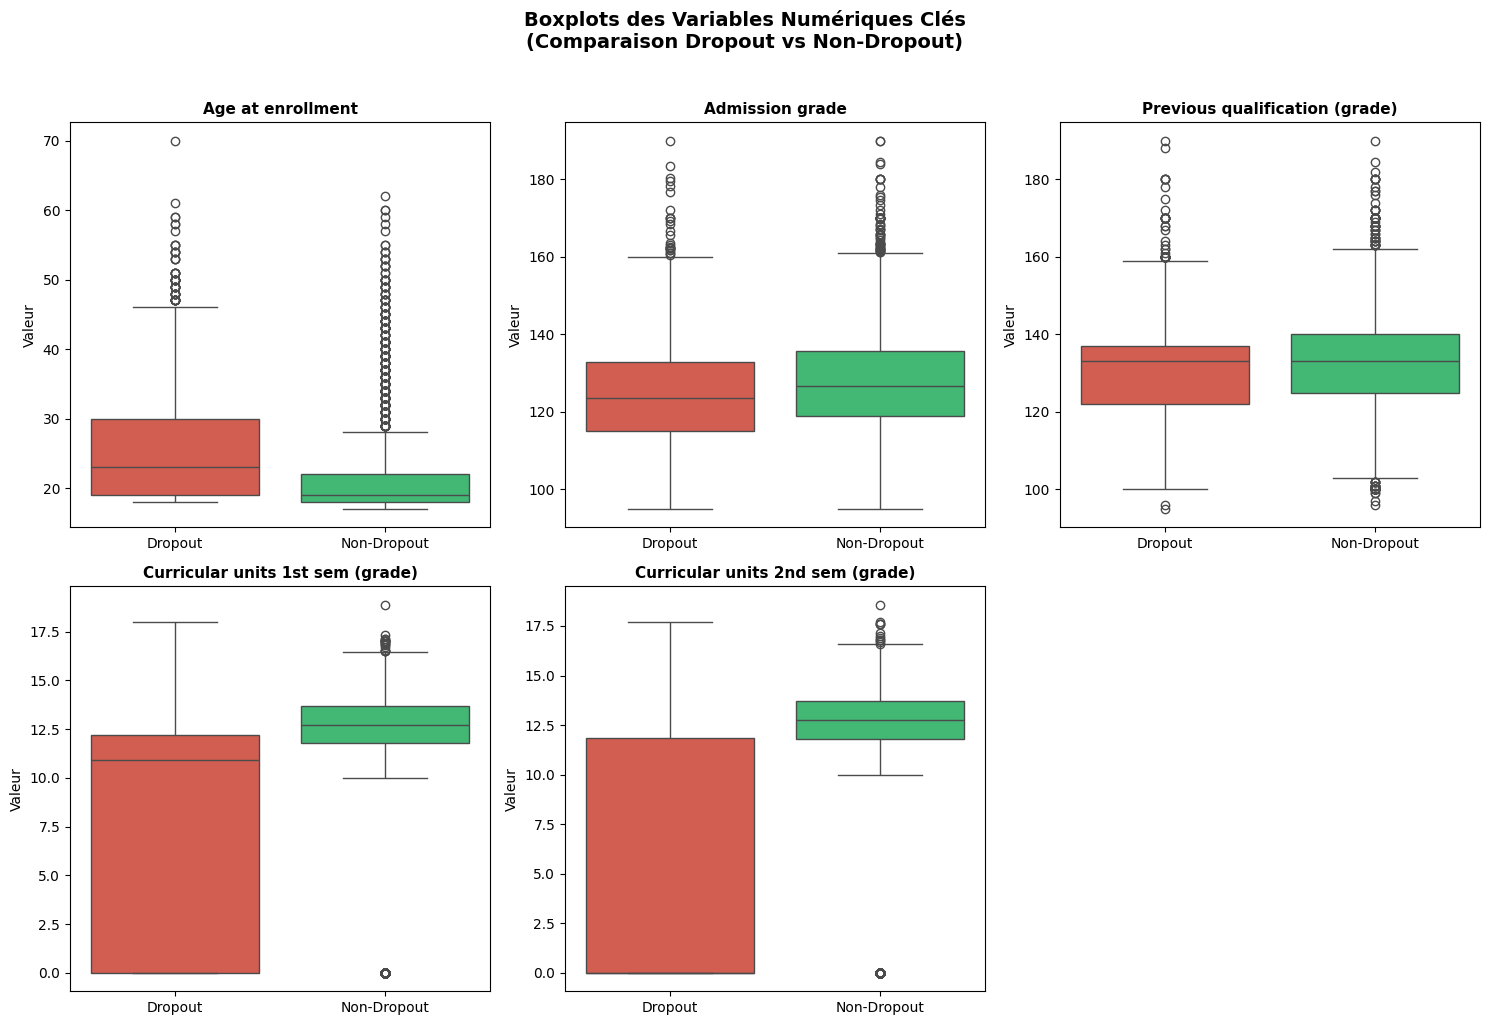


Interprétation des boxplots:
- Comparez les médianes (ligne horizontale) entre Dropout et Non-Dropout
- Des différences marquées suggèrent un pouvoir prédictif de la variable


In [15]:
# Sélection des variables numériques principales
numeric_cols = [
    "Age at enrollment",
    "Admission grade",
    "Previous qualification (grade)",
    "Curricular units 1st sem (grade)",
    "Curricular units 2nd sem (grade)",
]

# Création des boxplots avec seaborn (évite les warnings)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    sns.boxplot(
        data=df,
        x="Dropout_Binary",
        y=col,
        hue="Dropout_Binary",
        hue_order=BINARY_TARGET_ORDER,
        palette=BINARY_TARGET_COLORS,
        legend=False,
        ax=ax,
    )
    ax.set_title(col, fontsize=11, weight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("Valeur")

# Supprimer le dernier subplot vide
axes[-1].axis("off")

plt.suptitle(
    "Boxplots des Variables Numériques Clés\n(Comparaison Dropout vs Non-Dropout)",
    fontsize=14,
    weight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

print("\nInterprétation des boxplots:")
print("- Comparez les médianes (ligne horizontale) entre Dropout et Non-Dropout")
print("- Des différences marquées suggèrent un pouvoir prédictif de la variable")

### Outlier -> IQR

- Uniquement sur les variables continues

In [16]:
# Variables CONTINUES uniquement (exclure les catégorielles encodées en numérique)
continuous_cols = [
    "Age at enrollment",
    "Admission grade",
    "Previous qualification (grade)",
    "Curricular units 1st sem (credited)",
    "Curricular units 1st sem (enrolled)",
    "Curricular units 1st sem (evaluations)",
    "Curricular units 1st sem (approved)",
    "Curricular units 1st sem (grade)",
    "Curricular units 1st sem (without evaluations)",
    "Curricular units 2nd sem (credited)",
    "Curricular units 2nd sem (enrolled)",
    "Curricular units 2nd sem (evaluations)",
    "Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (grade)",
    "Curricular units 2nd sem (without evaluations)",
    "Unemployment rate",
    "Inflation rate",
    "GDP",
]

# Variables catégorielles exclues (même si encodées en numérique)
categorical_excluded = [
    "Marital status",
    "Application mode",
    "Application order",
    "Course",
    "Daytime/evening attendance",
    "Previous qualification",
    "Nacionality",
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation",
    "Displaced",
    "Educational special needs",
    "Debtor",
    "Tuition fees up to date",
    "Gender",
    "Scholarship holder",
    "International",
]

print(f"Analyse de {len(continuous_cols)} variables continues")
print(f"Attention: Variables catégorielles exclues: {len(categorical_excluded)}\n")

outlier_summary = []
for col in continuous_cols:
    if col in df.columns:
        count, lower, upper = count_outliers_iqr(df, col)
        pct = (count / len(df)) * 100
        if count > 0:
            outlier_summary.append(
                {
                    "Variable": col,
                    "Outliers": count,
                    "Pourcentage": f"{pct:.2f}%",
                    "Borne inf": f"{lower:.2f}",
                    "Borne sup": f"{upper:.2f}",
                }
            )

outlier_df = pd.DataFrame(outlier_summary)
outlier_df = outlier_df.sort_values("Outliers", ascending=False)
display(outlier_df)

Analyse de 18 variables continues
Attention: Variables catégorielles exclues: 18



,Variable,Outliers,Pourcentage,Borne inf,Borne sup
13,Curricular units 2nd sem (grade),877,19.82%,6.87,17.21
7,Curricular units 1st sem (grade),726,16.41%,7.40,17.00
3,Curricular units 1st sem (credited),577,13.04%,0.00,0.00
9,Curricular units 2nd sem (credited),530,11.98%,0.00,0.00
0,Age at enrollment,441,9.97%,10.00,34.00
4,Curricular units 1st sem (enrolled),424,9.58%,2.00,10.00
10,Curricular units 2nd sem (enrolled),369,8.34%,2.00,10.00
8,Curricular units 1st sem (without evaluations),294,6.65%,0.00,0.00
14,Curricular units 2nd sem (without evaluations),282,6.37%,0.00,0.00
6,Curricular units 1st sem (approved),180,4.07%,-1.50,10.50


## Phase 3 : Analyse Bivariée - Variables Numériques vs Dropout

**Objectif** : Identifier quelles variables numériques différencient les étudiants qui abandonnent de ceux qui réussissent.

**Questions clés** :
- Les Dropout ont-ils des notes d'admission plus faibles ?
- L'âge est-il un facteur de risque ?
- La performance au 1er semestre prédit-elle l'abandon ?

### Notes d'admission vs Dropout

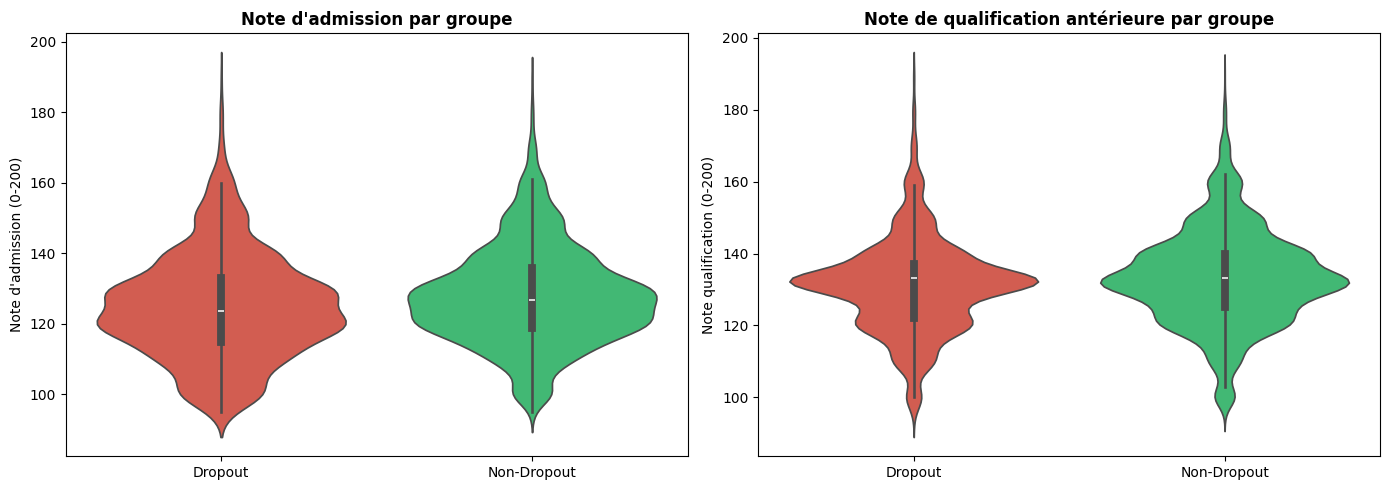

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Admission grade
sns.violinplot(
    data=df,
    x="Dropout_Binary",
    y="Admission grade",
    hue="Dropout_Binary",
    hue_order=BINARY_TARGET_ORDER,
    palette=BINARY_TARGET_COLORS,
    legend=False,
    ax=axes[0],
)
axes[0].set_title("Note d'admission par groupe", fontsize=12, weight="bold")
axes[0].set_xlabel("")
axes[0].set_ylabel("Note d'admission (0-200)")

# Previous qualification grade
sns.violinplot(
    data=df,
    x="Dropout_Binary",
    y="Previous qualification (grade)",
    hue="Dropout_Binary",
    hue_order=BINARY_TARGET_ORDER,
    palette=BINARY_TARGET_COLORS,
    legend=False,
    ax=axes[1],
)
axes[1].set_title("Note de qualification antérieure par groupe", fontsize=12, weight="bold")
axes[1].set_xlabel("")
axes[1].set_ylabel("Note qualification (0-200)")

plt.tight_layout()
plt.show()

### Stats comparatives

In [18]:
for col in ["Admission grade", "Previous qualification (grade)"]:
    dropout_df = df[df["Dropout_Binary"] == "Dropout"]
    non_dropout_df = df[df["Dropout_Binary"] == "Non-Dropout"]

    dropout_mean = dropout_df[col].mean()
    non_dropout_mean = non_dropout_df[col].mean()
    diff = non_dropout_mean - dropout_mean
    print(f"\n   {col}:")
    print(f"- Dropout:     {dropout_mean:.1f}")
    print(f"- Non-Dropout: {non_dropout_mean:.1f}")
    print(f"- Différence:  {diff:+.1f} points ({'Significatif' if abs(diff) > 5 else 'Faible'})")


   Admission grade:
- Dropout:     125.0
- Non-Dropout: 127.9
- Différence:  +3.0 points (Faible)

   Previous qualification (grade):
- Dropout:     131.1
- Non-Dropout: 133.3
- Différence:  +2.2 points (Faible)


### Âge à l'inscription vs Dropout

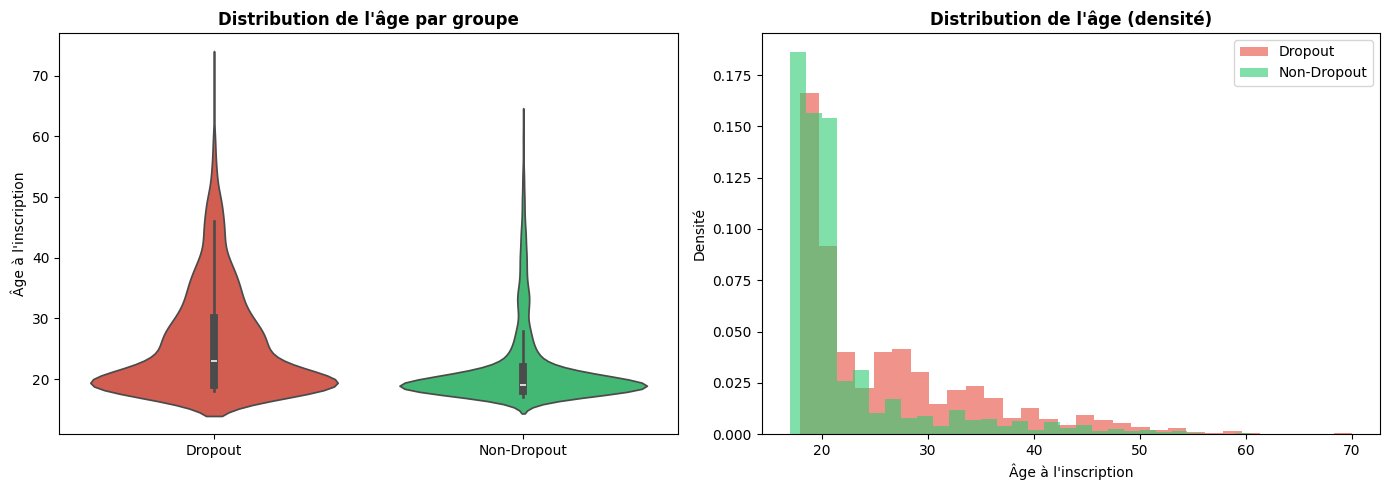

,mean_age,median_age,min_age,max_age
Dropout_Binary,,,,
Dropout,26.1,23.0,18,70
Non-Dropout,21.9,19.0,17,62


Les étudiants en dropout sont en moyenne 4.2 ans plus âgés que les étudiants non-dropout.


In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Violin plot
sns.violinplot(
    data=df,
    x="Dropout_Binary",
    y="Age at enrollment",
    hue="Dropout_Binary",
    hue_order=BINARY_TARGET_ORDER,
    palette=BINARY_TARGET_COLORS,
    legend=False,
    ax=axes[0],
)
axes[0].set_title("Distribution de l'âge par groupe", fontsize=12, weight="bold")
axes[0].set_xlabel("")
axes[0].set_ylabel("Âge à l'inscription")

# Histogramme superposé
for label, color in [("Dropout", "#e74c3c"), ("Non-Dropout", "#2ecc71")]:
    subset = df[df["Dropout_Binary"] == label]["Age at enrollment"]
    axes[1].hist(subset, bins=30, alpha=0.6, label=label, color=color, density=True)

axes[1].set_title("Distribution de l'âge (densité)", fontsize=12, weight="bold")
axes[1].set_xlabel("Âge à l'inscription")
axes[1].set_ylabel("Densité")
axes[1].legend()

plt.tight_layout()
plt.show()

age_stats = (
    df.groupby("Dropout_Binary")["Age at enrollment"]
    .agg(
        mean_age="mean",
        median_age="median",
        min_age="min",
        max_age="max",
    )
    .round({"mean_age": 1})
)

display(age_stats)

age_diff = age_stats.loc["Dropout", "mean_age"] - age_stats.loc["Non-Dropout", "mean_age"]
interpretation = (
    f"Les étudiants en dropout sont en moyenne "
    f"{abs(age_diff):.1f} ans "
    f"{'plus âgés' if age_diff > 0 else 'plus jeunes'} "
    f"que les étudiants non-dropout."
)

print(interpretation)

### Performance 1er Semestre vs Dropout

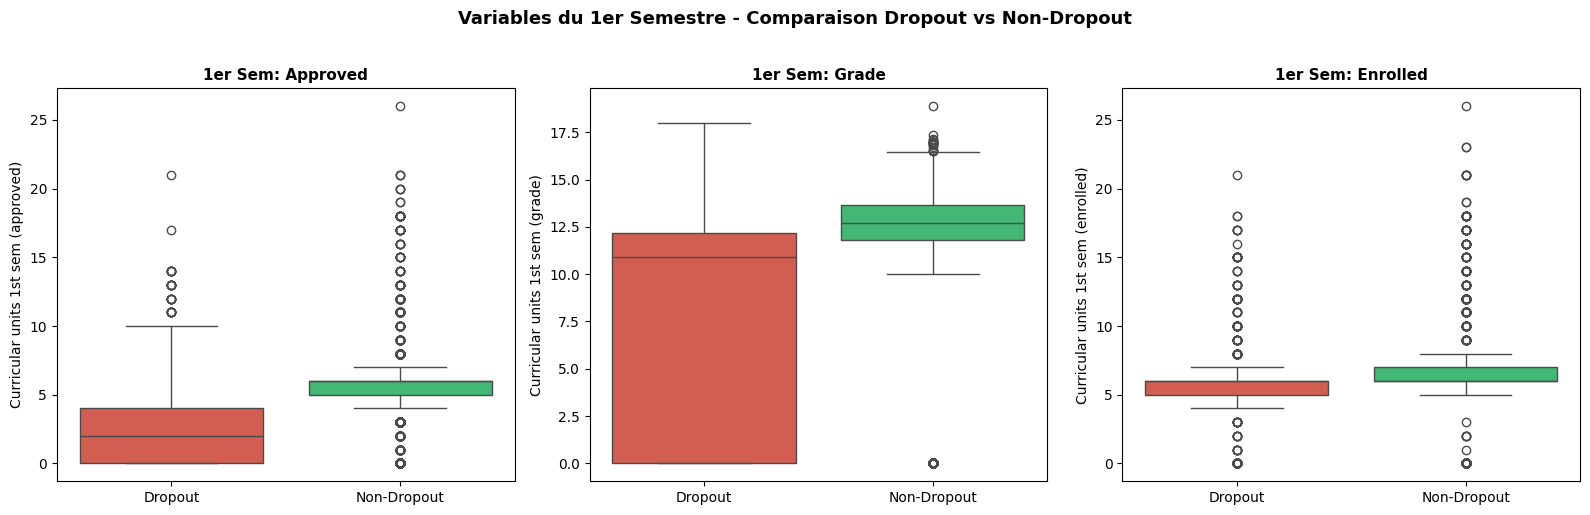


📈 Statistiques du 1er semestre:

   Unités validées au 1er semestre:
- Dropout:     2.55 unités en moyenne
- Non-Dropout: 5.73 unités en moyenne
- Ratio:       2.2x plus d'unités validées pour Non-Dropout

   Note moyenne au 1er semestre:
- Dropout:     7.26/20
- Non-Dropout: 12.24/20


In [20]:
sem1_cols = [
    "Curricular units 1st sem (approved)",
    "Curricular units 1st sem (grade)",
    "Curricular units 1st sem (enrolled)",
]

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, col in enumerate(sem1_cols):
    sns.boxplot(
        data=df,
        x="Dropout_Binary",
        y=col,
        hue="Dropout_Binary",
        hue_order=BINARY_TARGET_ORDER,
        palette=BINARY_TARGET_COLORS,
        legend=False,
        ax=axes[i],
    )
    # Titre simplifié
    short_name = col.replace("Curricular units 1st sem ", "").replace("(", "").replace(")", "")
    axes[i].set_title(f"1er Sem: {short_name.capitalize()}", fontsize=11, weight="bold")
    axes[i].set_xlabel("")

plt.suptitle(
    "Variables du 1er Semestre - Comparaison Dropout vs Non-Dropout",
    fontsize=13,
    weight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

# Statistiques clés
print("\n📈 Statistiques du 1er semestre:")
key_col = "Curricular units 1st sem (approved)"
dropout_val = df[df["Dropout_Binary"] == "Dropout"][key_col].mean()
non_dropout_val = df[df["Dropout_Binary"] == "Non-Dropout"][key_col].mean()

print("\n   Unités validées au 1er semestre:")
print(f"- Dropout:     {dropout_val:.2f} unités en moyenne")
print(f"- Non-Dropout: {non_dropout_val:.2f} unités en moyenne")
print(
    f"- Ratio:       {non_dropout_val / max(dropout_val, 0.01):.1f}x plus d'unités validées pour Non-Dropout"
)

key_col2 = "Curricular units 1st sem (grade)"
dropout_grade = df[df["Dropout_Binary"] == "Dropout"][key_col2].mean()
non_dropout_grade = df[df["Dropout_Binary"] == "Non-Dropout"][key_col2].mean()
print("\n   Note moyenne au 1er semestre:")
print(f"- Dropout:     {dropout_grade:.2f}/20")
print(f"- Non-Dropout: {non_dropout_grade:.2f}/20")

### Performance 2ème Semestre vs Dropout

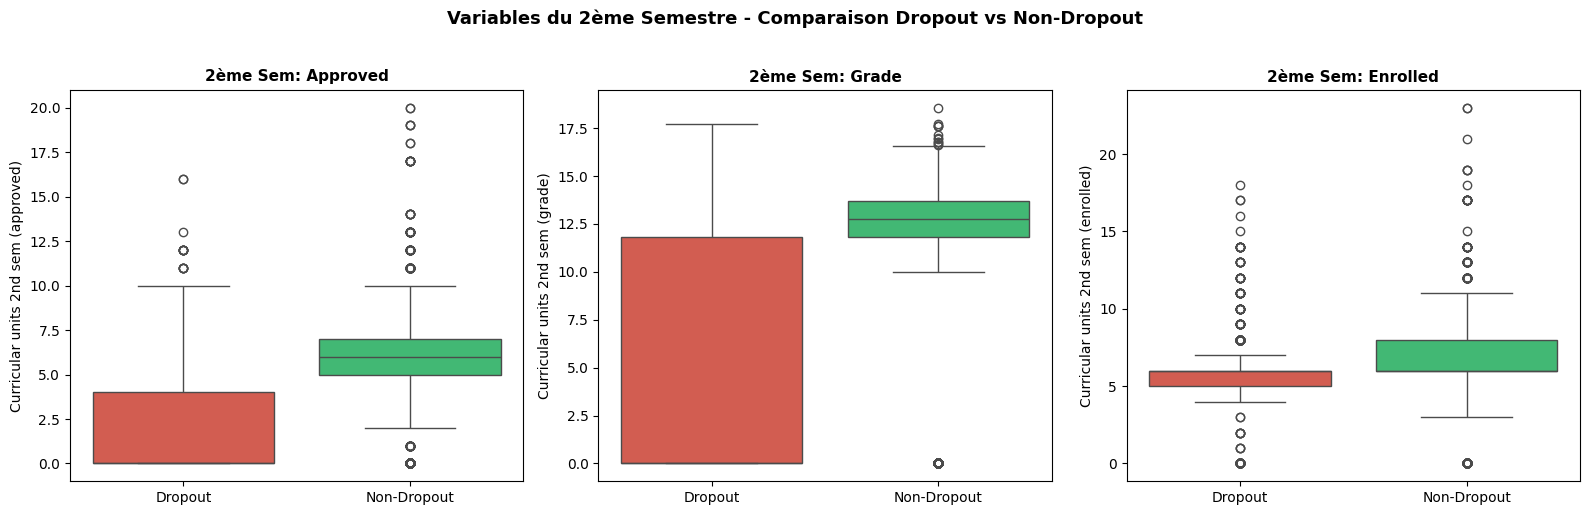


📈 Comparaison évolution entre semestres:

   | Groupe       | Sem 1 (approved) | Sem 2 (approved) | Évolution |
   |--------------|------------------|------------------|-----------|
   | Dropout      |             2.55 |             1.94 |     -0.61 |
   | Non-Dropout  |             5.73 |             5.62 |     -0.11 |


In [21]:
sem2_cols = [
    "Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (grade)",
    "Curricular units 2nd sem (enrolled)",
]

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, col in enumerate(sem2_cols):
    sns.boxplot(
        data=df,
        x="Dropout_Binary",
        y=col,
        hue="Dropout_Binary",
        hue_order=BINARY_TARGET_ORDER,
        palette=BINARY_TARGET_COLORS,
        legend=False,
        ax=axes[i],
    )
    short_name = col.replace("Curricular units 2nd sem ", "").replace("(", "").replace(")", "")
    axes[i].set_title(f"2ème Sem: {short_name.capitalize()}", fontsize=11, weight="bold")
    axes[i].set_xlabel("")

plt.suptitle(
    "Variables du 2ème Semestre - Comparaison Dropout vs Non-Dropout",
    fontsize=13,
    weight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

# Comparaison 1er vs 2ème semestre
print("\n📈 Comparaison évolution entre semestres:")
print("\n   | Groupe       | Sem 1 (approved) | Sem 2 (approved) | Évolution |")
print("   |--------------|------------------|------------------|-----------|")

for group in BINARY_TARGET_ORDER:
    sem1_mean = df[df["Dropout_Binary"] == group]["Curricular units 1st sem (approved)"].mean()
    sem2_mean = df[df["Dropout_Binary"] == group]["Curricular units 2nd sem (approved)"].mean()
    evolution = sem2_mean - sem1_mean
    print(f"   | {group:12} | {sem1_mean:16.2f} | {sem2_mean:16.2f} | {evolution:+9.2f} |")

## Phase 3.2 : Variables Catégorielles vs Dropout

**Objectif** : Identifier quelles catégories sont associées à un risque plus élevé de Dropout.

**Questions clés** :
- Certains programmes ont-ils plus d'abandons ?
- Les boursiers abandonnent-ils moins ?
- Le genre, l'état civil ou les cours du soir influencent-ils le Dropout ?

### On check les variables binaires vs Dropout + Percentage

In [22]:
# Variables binaires à analyser
binary_vars = [
    ("Gender", {0: "Femme", 1: "Homme"}),
    ("Scholarship holder", {0: "Non boursier", 1: "Boursier"}),
    ("Debtor", {0: "Non débiteur", 1: "Débiteur"}),
    ("Tuition fees up to date", {0: "Non à jour", 1: "À jour"}),
    ("Displaced", {0: "Local", 1: "Déplacé"}),
    ("International", {0: "National", 1: "International"}),
]

# Calculer le taux de dropout pour chaque variable
results = []
for var, labels in binary_vars:
    for val, label in labels.items():
        subset = df[df[var] == val]
        total = len(subset)
        dropout_count = len(subset[subset["Dropout_Binary"] == "Dropout"])
        dropout_rate = (dropout_count / total * 100) if total > 0 else 0
        results.append(
            {
                "Variable": var,
                "Catégorie": label,
                "Total": total,
                "Dropout": dropout_count,
                "Taux Dropout (%)": round(dropout_rate, 1),
            }
        )

results_df = pd.DataFrame(results)
display(results_df)

,Variable,Catégorie,Total,Dropout,Taux Dropout (%)
0,Gender,Femme,2868,720,25.1
1,Gender,Homme,1556,701,45.1
2,Scholarship holder,Non boursier,3325,1287,38.7
3,Scholarship holder,Boursier,1099,134,12.2
4,Debtor,Non débiteur,3921,1109,28.3
5,Debtor,Débiteur,503,312,62.0
6,Tuition fees up to date,Non à jour,528,457,86.6
7,Tuition fees up to date,À jour,3896,964,24.7
8,Displaced,Local,1998,752,37.6
9,Displaced,Déplacé,2426,669,27.6


### Quels facteurs augmentent le risque

In [23]:
for var, labels in binary_vars:
    rates = results_df[results_df["Variable"] == var]["Taux Dropout (%)"].values
    if len(rates) == 2 and abs(rates[0] - rates[1]) > 5:
        higher = labels[0] if rates[0] > rates[1] else labels[1]
        diff = abs(rates[0] - rates[1]) / 100.0
        print(f"- {var}: '{higher}' => {diff:+.1%} de dropout")

- Gender: 'Homme' => +20.0% de dropout
- Scholarship holder: 'Non boursier' => +26.5% de dropout
- Debtor: 'Débiteur' => +33.7% de dropout
- Tuition fees up to date: 'Non à jour' => +61.9% de dropout
- Displaced: 'Local' => +10.0% de dropout


### Le petit graph qui va avec

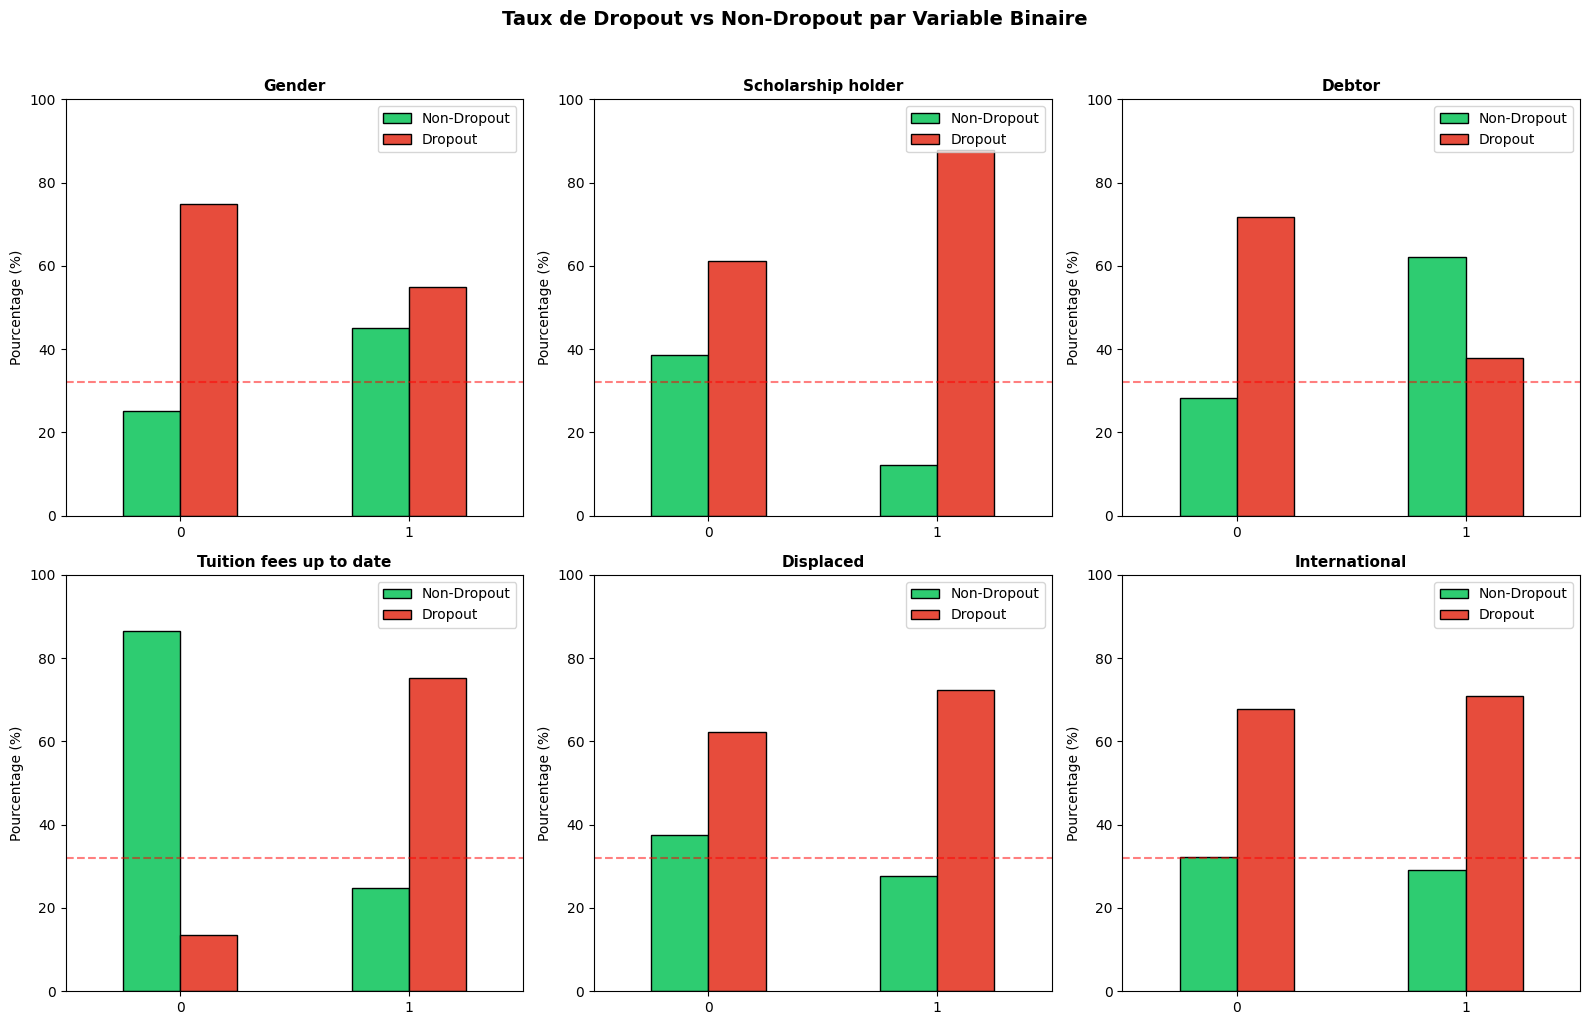


Taux de dropout global: 32.1%
   (Ligne rouge pointillée = référence)


In [24]:
# Variables binaires (sans Daytime/evening attendance)
binary_vars_simple = [
    "Gender",
    "Scholarship holder",
    "Debtor",
    "Tuition fees up to date",
    "Displaced",
    "International",
]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, var in enumerate(binary_vars_simple):
    ax = axes[i]

    # Calculer les pourcentages
    cross_tab = pd.crosstab(df[var], df["Dropout_Binary"], normalize="index") * 100

    # Plot
    cross_tab.plot(kind="bar", ax=ax, color=["#2ecc71", "#e74c3c"], edgecolor="black")
    ax.set_title(f"{var}", fontsize=11, weight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("Pourcentage (%)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.legend(["Non-Dropout", "Dropout"], loc="upper right")
    ax.set_ylim(0, 100)

    # Ajouter la ligne de référence (taux global)
    global_dropout_rate = (df["Dropout_Binary"] == "Dropout").mean() * 100
    ax.axhline(
        y=global_dropout_rate,
        color="red",
        linestyle="--",
        alpha=0.5,
        label="Taux global",
    )

plt.suptitle(
    "Taux de Dropout vs Non-Dropout par Variable Binaire",
    fontsize=14,
    weight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

print(f"\nTaux de dropout global: {global_dropout_rate:.1f}%")
print("   (Ligne rouge pointillée = référence)")

### Programme d'études vs Dropout

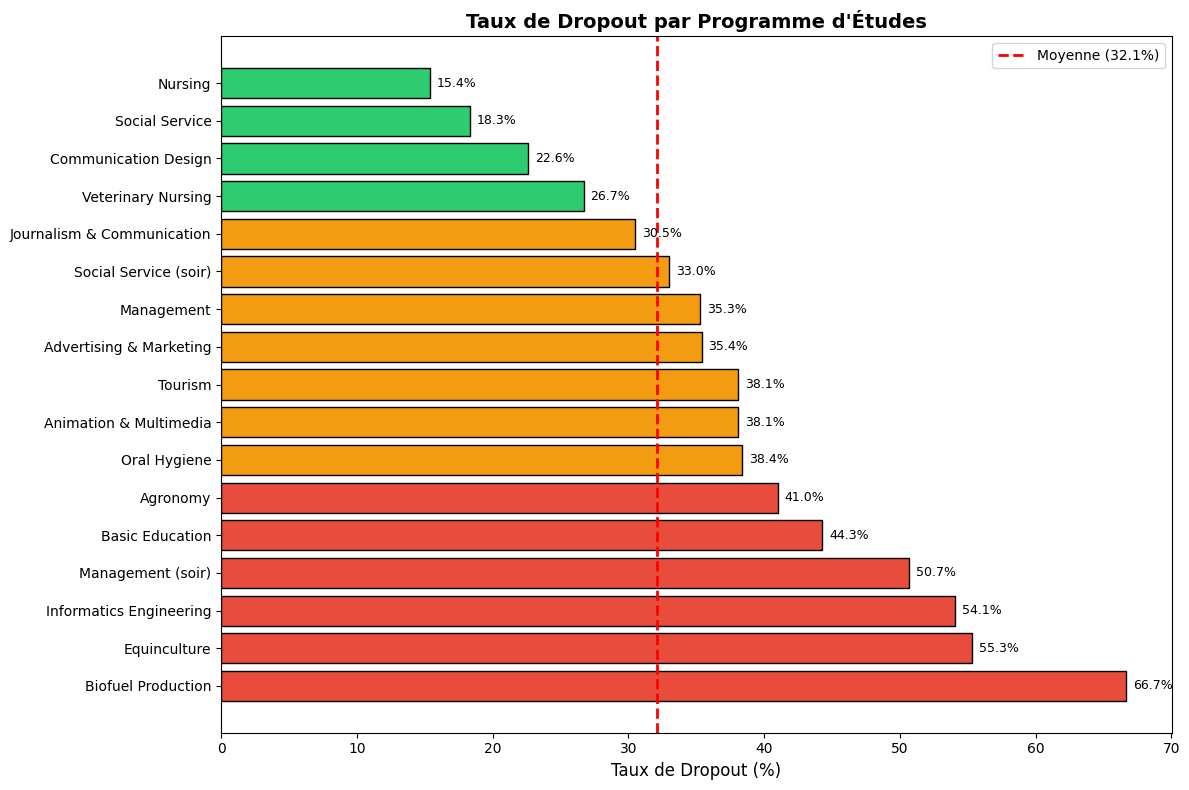


Programmes à HAUT risque (>40% dropout):
- Biofuel Production: 66.7% (8/12 étudiants)
- Equinculture: 55.3% (78/141 étudiants)
- Informatics Engineering: 54.1% (92/170 étudiants)
- Management (soir): 50.7% (136/268 étudiants)
- Basic Education: 44.3% (85/192 étudiants)
- Agronomy: 41.0% (86/210 étudiants)

Programmes à FAIBLE risque (<25% dropout):
- Communication Design: 22.6% (51/226 étudiants)
- Social Service: 18.3% (65/355 étudiants)
- Nursing: 15.4% (118/766 étudiants)


In [25]:
# Mapping des codes de programme
course_mapping = {
    33: "Biofuel Production",
    171: "Animation & Multimedia",
    8014: "Social Service (soir)",
    9003: "Agronomy",
    9070: "Communication Design",
    9085: "Veterinary Nursing",
    9119: "Informatics Engineering",
    9130: "Equinculture",
    9147: "Management",
    9238: "Social Service",
    9254: "Tourism",
    9500: "Nursing",
    9556: "Oral Hygiene",
    9670: "Advertising & Marketing",
    9773: "Journalism & Communication",
    9853: "Basic Education",
    9991: "Management (soir)",
}

# Calculer le taux de dropout par programme
course_stats = (
    df.groupby("Course")
    .agg({"Dropout_Binary": lambda x: (x == "Dropout").sum(), "Target": "count"})
    .rename(columns={"Dropout_Binary": "Dropouts", "Target": "Total"})
)

course_stats["Taux Dropout (%)"] = (course_stats["Dropouts"] / course_stats["Total"] * 100).round(1)
course_stats["Programme"] = course_stats.index.map(course_mapping)
course_stats = course_stats.sort_values("Taux Dropout (%)", ascending=False)

# Visualisation
fig, ax = plt.subplots(figsize=(12, 8))
colors = [
    "#e74c3c" if x > 40 else "#f39c12" if x > 30 else "#2ecc71"
    for x in course_stats["Taux Dropout (%)"]
]

bars = ax.barh(
    course_stats["Programme"],
    course_stats["Taux Dropout (%)"],
    color=colors,
    edgecolor="black",
)
ax.set_xlabel("Taux de Dropout (%)", fontsize=12)
ax.set_title("Taux de Dropout par Programme d'Études", fontsize=14, weight="bold")
ax.axvline(
    x=global_dropout_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Moyenne ({global_dropout_rate:.1f}%)",
)
ax.legend()

# Ajouter les valeurs sur les barres
for bar, val in zip(bars, course_stats["Taux Dropout (%)"]):
    ax.text(
        bar.get_width() + 0.5,
        bar.get_y() + bar.get_height() / 2,
        f"{val}%",
        va="center",
        fontsize=9,
    )

plt.tight_layout()
plt.show()

# Résumé
print("\nProgrammes à HAUT risque (>40% dropout):")
high_risk = course_stats[course_stats["Taux Dropout (%)"] > 40]
for _, row in high_risk.iterrows():
    print(
        f"- {row['Programme']}: {row['Taux Dropout (%)']}% ({row['Dropouts']}/{row['Total']} étudiants)"
    )

print("\nProgrammes à FAIBLE risque (<25% dropout):")
low_risk = course_stats[course_stats["Taux Dropout (%)"] < 25]
for _, row in low_risk.iterrows():
    print(
        f"- {row['Programme']}: {row['Taux Dropout (%)']}% ({row['Dropouts']}/{row['Total']} étudiants)"
    )

### Est-ce que le status marital joue ?

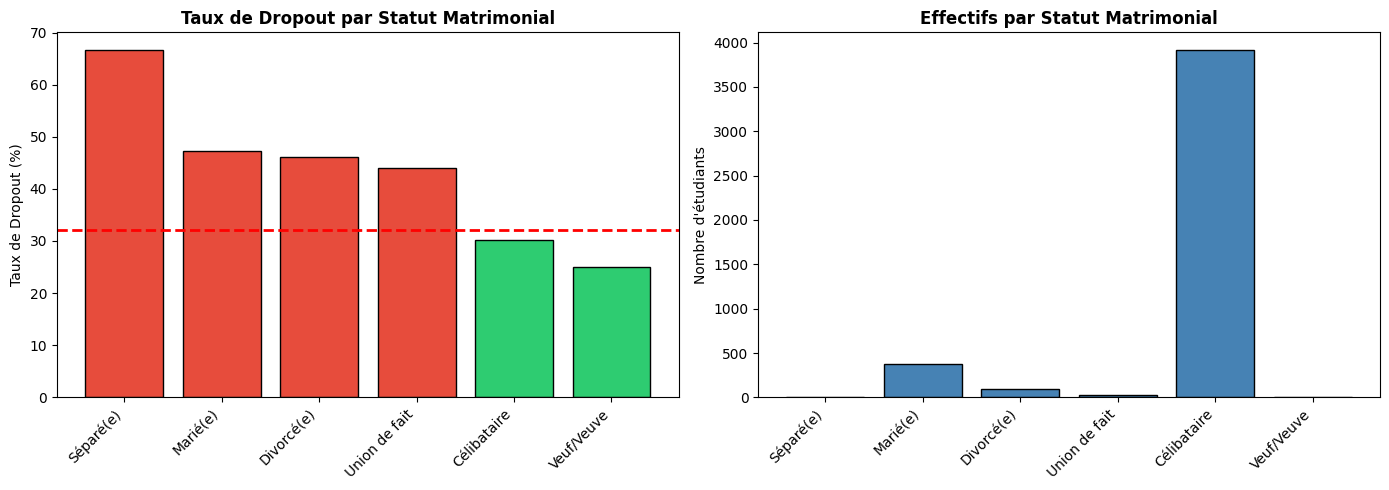


📋 Tableau récapitulatif:


,Statut,Total,Dropouts,Taux Dropout (%)
0,Séparé(e),6,4,66.7
1,Marié(e),379,179,47.2
2,Divorcé(e),91,42,46.2
3,Union de fait,25,11,44.0
4,Célibataire,3919,1184,30.2
5,Veuf/Veuve,4,1,25.0



💡 Note: La majorité des étudiants sont célibataires (3919 sur 4424)


In [26]:
# Mapping des codes d'état civil
marital_mapping = {
    1: "Célibataire",
    2: "Marié(e)",
    3: "Veuf/Veuve",
    4: "Divorcé(e)",
    5: "Union de fait",
    6: "Séparé(e)",
}

# Calculer le taux de dropout par statut matrimonial
marital_stats = (
    df.groupby("Marital status")
    .agg({"Dropout_Binary": lambda x: (x == "Dropout").sum(), "Target": "count"})
    .rename(columns={"Dropout_Binary": "Dropouts", "Target": "Total"})
)

marital_stats["Taux Dropout (%)"] = (
    marital_stats["Dropouts"] / marital_stats["Total"] * 100
).round(1)
marital_stats["Statut"] = marital_stats.index.map(marital_mapping)
marital_stats = marital_stats.sort_values("Taux Dropout (%)", ascending=False)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1: Taux de dropout
ax1 = axes[0]
x_positions = range(len(marital_stats))
colors = [
    "#e74c3c" if x > global_dropout_rate else "#2ecc71" for x in marital_stats["Taux Dropout (%)"]
]
bars1 = ax1.bar(x_positions, marital_stats["Taux Dropout (%)"], color=colors, edgecolor="black")
ax1.axhline(y=global_dropout_rate, color="red", linestyle="--", linewidth=2)
ax1.set_ylabel("Taux de Dropout (%)")
ax1.set_title("Taux de Dropout par Statut Matrimonial", fontsize=12, weight="bold")
ax1.set_xticks(x_positions)
ax1.set_xticklabels(marital_stats["Statut"], rotation=45, ha="right")

# Graphique 2: Effectifs
ax2 = axes[1]
bars2 = ax2.bar(x_positions, marital_stats["Total"], color="steelblue", edgecolor="black")
ax2.set_ylabel("Nombre d'étudiants")
ax2.set_title("Effectifs par Statut Matrimonial", fontsize=12, weight="bold")
ax2.set_xticks(x_positions)
ax2.set_xticklabels(marital_stats["Statut"], rotation=45, ha="right")

plt.tight_layout()
plt.show()

# Tableau récapitulatif
print("\n📋 Tableau récapitulatif:")
display(marital_stats[["Statut", "Total", "Dropouts", "Taux Dropout (%)"]].reset_index(drop=True))

print(
    f"\n💡 Note: La majorité des étudiants sont célibataires ({marital_stats[marital_stats['Statut'] == 'Célibataire']['Total'].values[0]} sur {len(df)})"
)

## Phase 4 : Analyse de Corrélation

**Objectif** : Identifier les variables les plus corrélées au Dropout et détecter les multicolinéarités.

**Questions clés** :
- Quelles variables numériques sont les plus liées au Dropout ?
- Y a-t-il des variables redondantes (fortement corrélées entre elles) ?
- Quelles variables prioriser pour le machine learning ?

### Matrice de corrélation

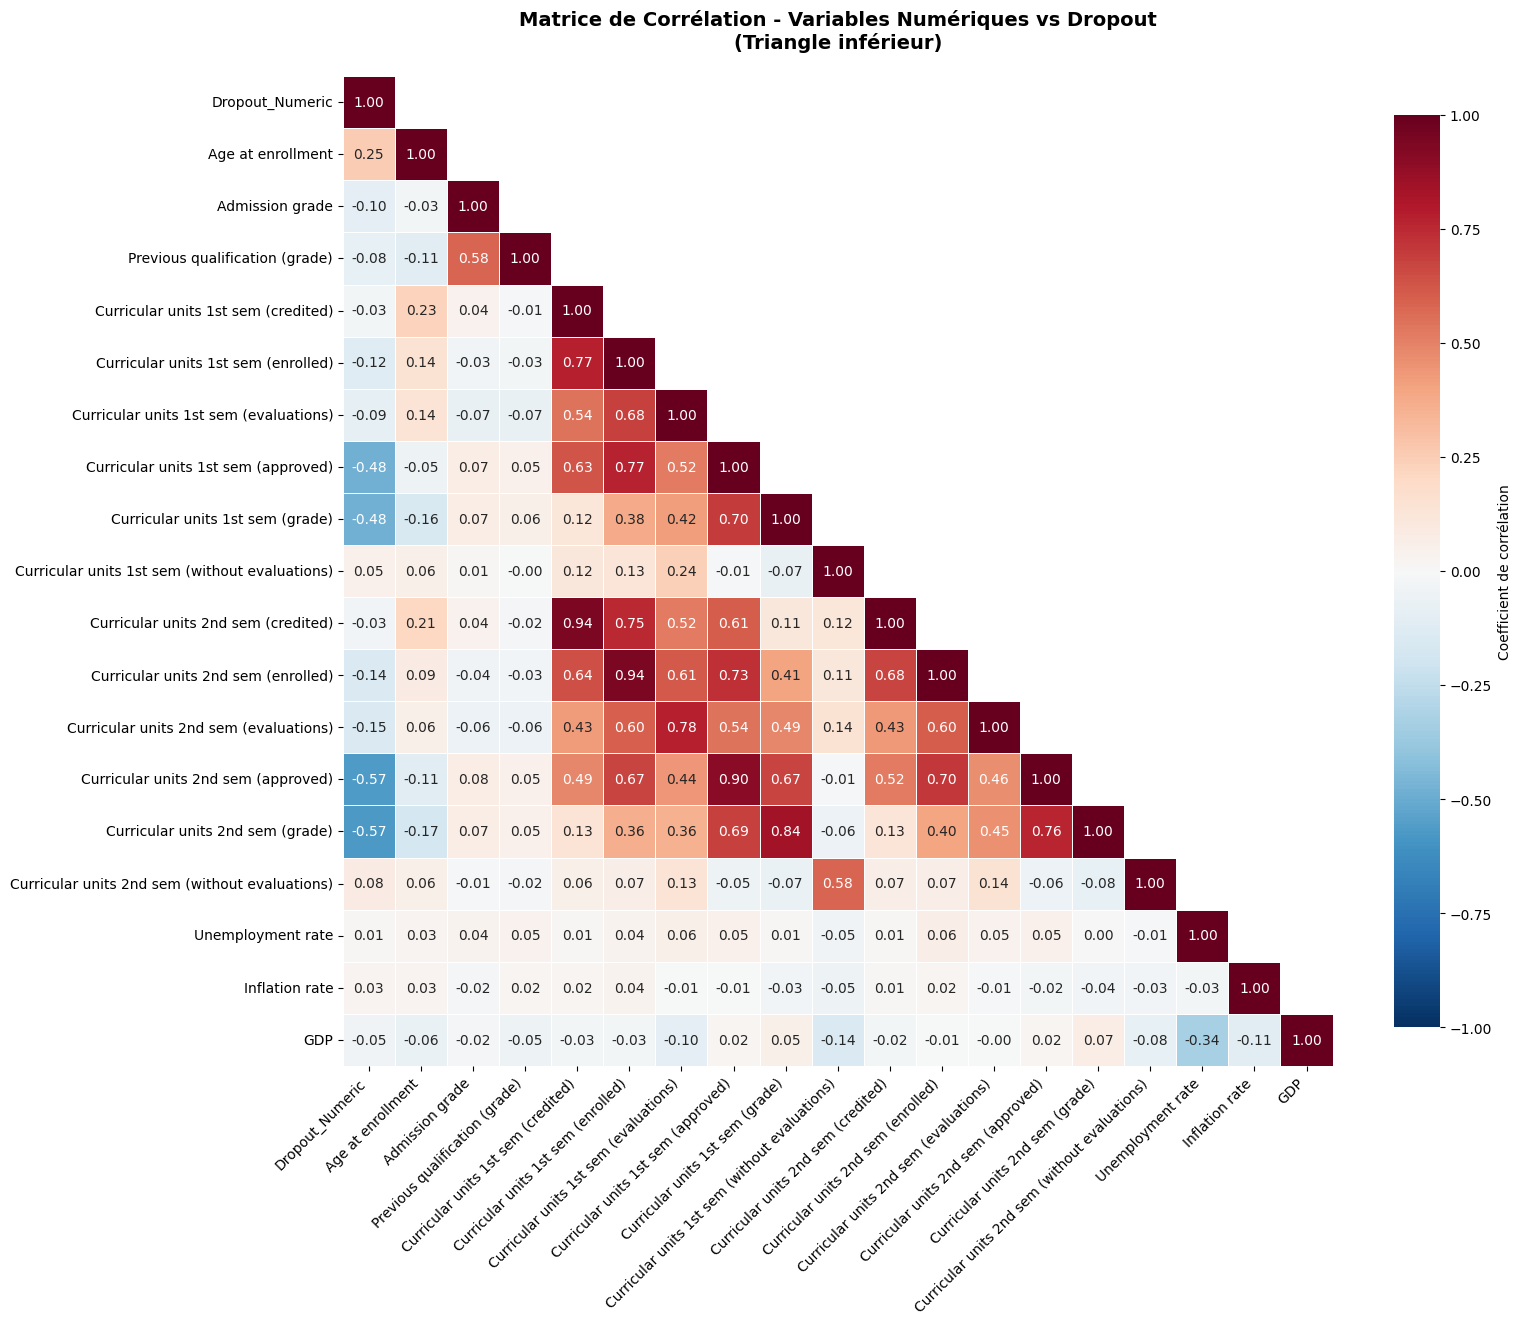

Interprétation de la heatmap :
- Rouge foncé : Corrélation négative forte (quand l'une augmente, l'autre diminue)
- Bleu foncé : Corrélation positive forte (les deux augmentent ensemble)
- Blanc/Clair : Pas de corrélation significative


In [27]:
# Création d'une variable numérique pour Dropout (1 = Dropout, 0 = Non-Dropout)
df["Dropout_Numeric"] = (df["Dropout_Binary"] == "Dropout").astype(int)

# Sélection des variables numériques pour la corrélation
# On exclut les variables catégorielles encodées en numérique
numeric_for_corr = [
    "Dropout_Numeric",  # Notre variable cible
    "Age at enrollment",
    "Admission grade",
    "Previous qualification (grade)",
    # Performance 1er semestre
    "Curricular units 1st sem (credited)",
    "Curricular units 1st sem (enrolled)",
    "Curricular units 1st sem (evaluations)",
    "Curricular units 1st sem (approved)",
    "Curricular units 1st sem (grade)",
    "Curricular units 1st sem (without evaluations)",
    # Performance 2ème semestre
    "Curricular units 2nd sem (credited)",
    "Curricular units 2nd sem (enrolled)",
    "Curricular units 2nd sem (evaluations)",
    "Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (grade)",
    "Curricular units 2nd sem (without evaluations)",
    # Indicateurs économiques
    "Unemployment rate",
    "Inflation rate",
    "GDP",
]

# Calcul de la matrice de corrélation
corr_matrix = df[numeric_for_corr].corr()

# Visualisation avec heatmap
fig, ax = plt.subplots(figsize=(16, 14))

# Masque pour la partie triangulaire supérieure (évite les doublons)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Heatmap avec annotations
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",  # Rouge = corrélation négative, Bleu = positive
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Coefficient de corrélation"},
    ax=ax,
)

ax.set_title(
    "Matrice de Corrélation - Variables Numériques vs Dropout\n(Triangle inférieur)",
    fontsize=14,
    fontweight="bold",
    pad=20,
)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("Interprétation de la heatmap :")
print("- Rouge foncé : Corrélation négative forte (quand l'une augmente, l'autre diminue)")
print("- Bleu foncé : Corrélation positive forte (les deux augmentent ensemble)")
print("- Blanc/Clair : Pas de corrélation significative")

### Correlation avec Dropout
- Facteur de risque - augmente le dropout
- Facteur protecteur - diminue le dropout

In [28]:
# Extraction des corrélations avec notre variable cible
# Tri par valeur absolue (pour voir les plus fortes, positives ou négatives)
# Affichage du Top 10
print("Top 10 Variables les plus corrélées au Dropout\n")
dropout_corr_top10 = (
    corr_matrix["Dropout_Numeric"]
    .drop("Dropout_Numeric")
    .to_frame(name="correlation")
    .assign(abs_corr=lambda x: x["correlation"].abs())
    .sort_values("abs_corr", ascending=False)
    .head(10)
    .assign(
        direction=lambda x: x["correlation"].apply(lambda v: "risque" if v > 0 else "protecteur"),
    )
    .drop(columns="abs_corr")
)

display(dropout_corr_top10)

Top 10 Variables les plus corrélées au Dropout



,correlation,direction
Curricular units 2nd sem (grade),-0.571792,protecteur
Curricular units 2nd sem (approved),-0.569500,protecteur
Curricular units 1st sem (grade),-0.480669,protecteur
Curricular units 1st sem (approved),-0.479112,protecteur
Age at enrollment,0.254215,risque
Curricular units 2nd sem (evaluations),-0.154999,protecteur
Curricular units 2nd sem (enrolled),-0.141515,protecteur
Curricular units 1st sem (enrolled),-0.124635,protecteur
Admission grade,-0.095806,protecteur
Curricular units 1st sem (evaluations),-0.090125,protecteur


### Graphique des correlations (top-10)

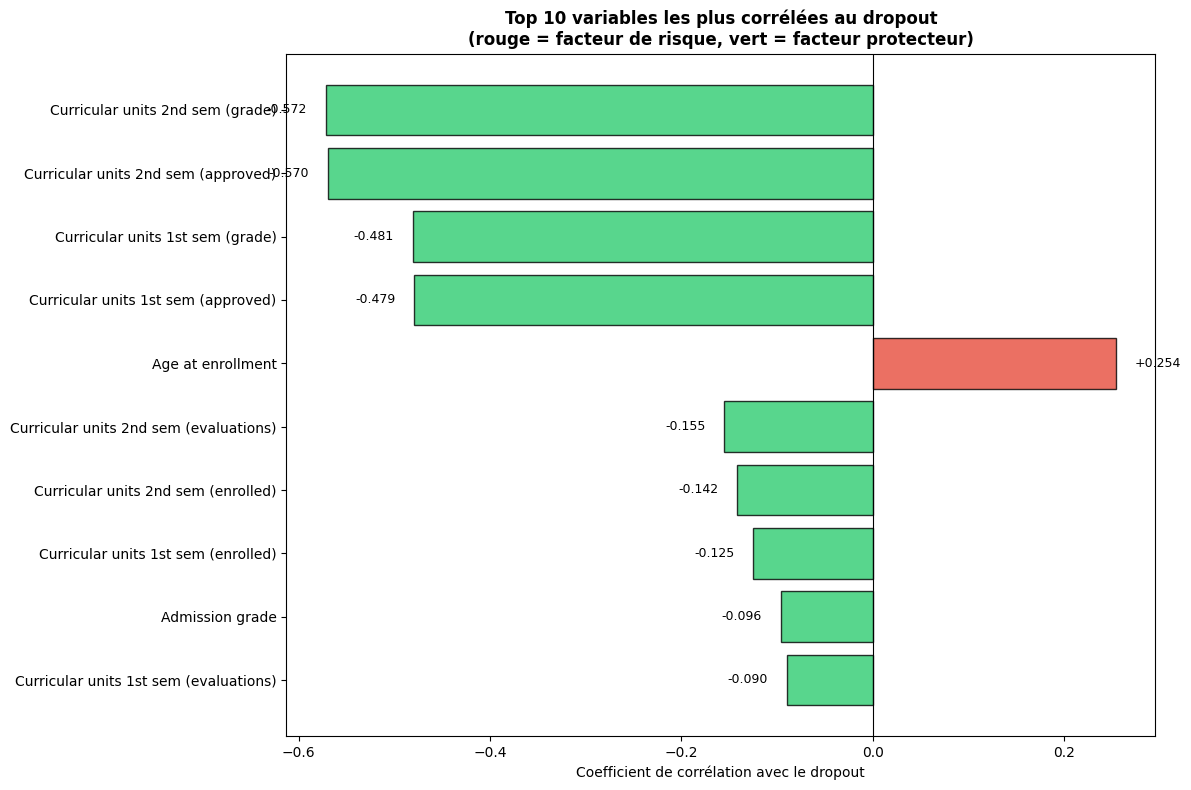

In [29]:
# Série à tracer
corr_values = dropout_corr_top10["correlation"]

# Couleurs selon le signe
colors = ["#e74c3c" if v > 0 else "#2ecc71" for v in corr_values]

# Visualisation
fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.barh(
    corr_values.index,
    corr_values.values,
    color=colors,
    edgecolor="black",
    alpha=0.8,
)

ax.invert_yaxis()
ax.axvline(x=0, color="black", linewidth=0.8)

ax.set_xlabel("Coefficient de corrélation avec le dropout")
ax.set_title(
    "Top 10 variables les plus corrélées au dropout\n"
    "(rouge = facteur de risque, vert = facteur protecteur)",
    fontsize=12,
    fontweight="bold",
)

# Annotations
for bar, val in zip(bars, corr_values.values):
    ax.text(
        val + 0.02 if val > 0 else val - 0.02,
        bar.get_y() + bar.get_height() / 2,
        f"{val:+.3f}",
        va="center",
        ha="left" if val > 0 else "right",
        fontsize=9,
    )

plt.tight_layout()
plt.show()

#### Correlation > .10

In [30]:
display(dropout_corr_top10[dropout_corr_top10["correlation"].abs() > 0.1])

,correlation,direction
Curricular units 2nd sem (grade),-0.571792,protecteur
Curricular units 2nd sem (approved),-0.569500,protecteur
Curricular units 1st sem (grade),-0.480669,protecteur
Curricular units 1st sem (approved),-0.479112,protecteur
Age at enrollment,0.254215,risque
Curricular units 2nd sem (evaluations),-0.154999,protecteur
Curricular units 2nd sem (enrolled),-0.141515,protecteur
Curricular units 1st sem (enrolled),-0.124635,protecteur


### Synthèse Phase 4 : Matrice de Corrélation

**Découvertes clés :**

| Aspect | Résultat |
|--------|----------|
| **Prédicteurs les plus forts** | Notes et unités validées du 2ème semestre (r ≈ -0.57) |
| **Facteur de risque positif** | Âge à l'inscription (+0.254) - étudiants plus âgés |
| **Indicateurs économiques** | Faible corrélation avec le dropout (< 0.05) |
| **Multicolinéarité détectée** | 11 paires avec \|r\| > 0.7 |

**Implications pour le Machine Learning :**
1. Les variables sem1 et sem2 sont fortement corrélées → risque de redondance
2. Prioriser les **grades** (notes) sur les autres métriques académiques
3. Le 2ème semestre est plus prédictif que le 1er
4. L'âge est un facteur de risque à ne pas négliger

## Phase 5 : Feature Engineering

**Objectif** : Créer de nouvelles variables pour améliorer la prédiction et réduire la multicolinéarité détectée en Phase 4.

**Transformations prévues :**
| Type | Description |
|------|-------------|
| **Discrétisation** | Âge → tranches (17-20, 21-25, 26-35, 36+) |
| **Regroupement** | Statut marital → Solo/Couple |
| **Regroupement** | Qualifications → Secondaire/Supérieur |
| **Regroupement** | Programmes → Domaines (Santé, Tech, Business...) |
| **Ratios** | Taux de réussite par semestre |
| **Agrégations** | Notes moyennes, tendance de performance |

### Discrétisation de l'âge

In [31]:
df = prepare_feature_engineering(df)
age_counts = df["Age_Group"].value_counts(dropna=False)
age_pct = df["Age_Group"].value_counts(normalize=True, dropna=False)

pd.concat([age_counts, age_pct], axis=1, keys=["count", "percentage"])

,count,percentage
Age_Group,,
17-20,2551,0.576627
21-25,828,0.187161
26-35,653,0.147604
36+,392,0.088608


### Taux de dropout par tranche d'age

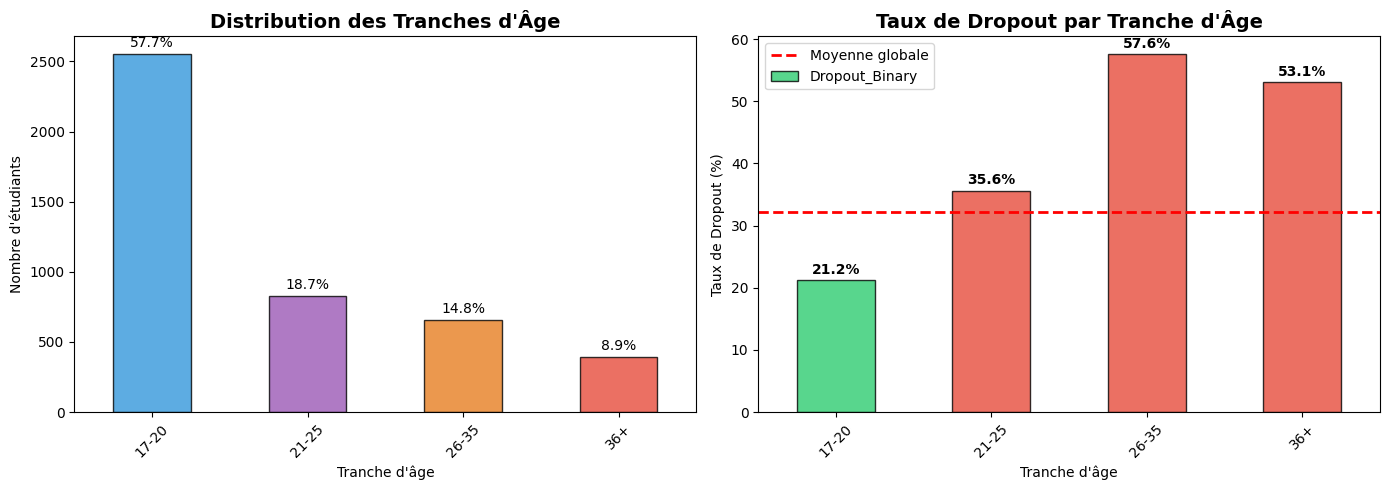

In [32]:
dropout_by_age = (
    df.groupby("Age_Group", observed=True)["Dropout_Binary"]
    .apply(lambda x: (x == "Dropout").mean() * 100)
    .sort_index()
)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution des tranches d'âge
colors = ["#3498db", "#9b59b6", "#e67e22", "#e74c3c"]
ax1 = axes[0]
age_dist = df["Age_Group"].value_counts().sort_index()
age_dist.plot(kind="bar", ax=ax1, color=colors, edgecolor="black", alpha=0.8)
ax1.set_title("Distribution des Tranches d'Âge", fontsize=14, fontweight="bold")
ax1.set_xlabel("Tranche d'âge")
ax1.set_ylabel("Nombre d'étudiants")
ax1.tick_params(axis="x", rotation=45)

# Ajouter les pourcentages sur les barres
for i, (idx, val) in enumerate(age_dist.items()):
    ax1.text(i, val + 50, f"{val / len(df) * 100:.1f}%", ha="center", fontsize=10)

# Taux de dropout par tranche
ax2 = axes[1]
colors_dropout = [
    "#2ecc71" if r < 30 else "#f39c12" if r < 35 else "#e74c3c" for r in dropout_by_age
]
dropout_by_age.plot(kind="bar", ax=ax2, color=colors_dropout, edgecolor="black", alpha=0.8)
ax2.axhline(
    y=df["Dropout_Binary"].apply(lambda x: x == "Dropout").mean() * 100,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Moyenne globale",
)
ax2.set_title("Taux de Dropout par Tranche d'Âge", fontsize=14, fontweight="bold")
ax2.set_xlabel("Tranche d'âge")
ax2.set_ylabel("Taux de Dropout (%)")
ax2.tick_params(axis="x", rotation=45)
ax2.legend()

# Ajouter les valeurs sur les barres
for i, (idx, val) in enumerate(dropout_by_age.items()):
    ax2.text(i, val + 1, f"{val:.1f}%", ha="center", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()

### Tableau récapitulatif des nouvelles features

## Récapitulatif des nouvelles features créées

In [33]:
# Liste des nouvelles features avec leurs statistiques
new_categorial_features = ["Age_Group", "Marital_Binary", "Education_Level", "Course_Domain",]
new_numerical_features = [
    "Success_Rate_Sem1",
    "Success_Rate_Sem2",
    "Avg_Grade",
    "Total_Approved",
    "Performance_Trend",
]

### Variable Catégorielles

In [34]:
for feat in new_categorial_features:
    dropout_rate = df.groupby(feat, observed=True)["Dropout_Binary"].apply(
        lambda x: (x == "Dropout").mean() * 100
    )
    max_rate = dropout_rate.max()
    min_rate = dropout_rate.min()
    spread = max_rate - min_rate
    print(f"  {feat}: écart {spread:.1f}% (min: {min_rate:.1f}%, max: {max_rate:.1f}%)")

  Age_Group: écart 36.3% (min: 21.2%, max: 57.6%)
  Marital_Binary: écart 16.4% (min: 30.6%, max: 47.0%)
  Education_Level: écart 9.8% (min: 31.1%, max: 40.8%)
  Course_Domain: écart 34.7% (min: 20.3%, max: 54.9%)


### Variables numériques (corrélation avec Dropout)

In [35]:
for feat in new_numerical_features:
    corr = df[feat].corr(df["Dropout_Numeric"])
    effect = "facteur de risque" if corr > 0 else "facteur protecteur"
    print(f"  {feat}: r = {corr:+.3f} ({effect})")

  Success_Rate_Sem1: r = -0.638 (facteur protecteur)
  Success_Rate_Sem2: r = -0.705 (facteur protecteur)
  Avg_Grade: r = -0.551 (facteur protecteur)
  Total_Approved: r = -0.537 (facteur protecteur)
  Performance_Trend: r = -0.225 (facteur protecteur)


### Synthèse Phase 5 : Feature Engineering

**9 nouvelles variables créées** pour améliorer l'analyse et préparer le Machine Learning.

#### Résultats clés :

| Type de transformation | Meilleure feature | Impact sur Dropout |
|------------------------|-------------------|-------------------|
| **Discrétisation** | Age_Group | Écart de 36.3% entre tranches |
| **Regroupement catégoriel** | Course_Domain | Écart de 34.7% entre domaines |
| **Ratio de performance** | Success_Rate_Sem2 | r = -0.705 (le plus fort !) |
| **Agrégation** | Avg_Grade | r = -0.551 |

#### Découvertes importantes :

1. **Le taux de réussite est plus prédictif que les notes brutes**
   - `Success_Rate_Sem2` (r = -0.705) surpasse même les notes individuelles
   - Cela confirme l'importance du ratio approved/enrolled

2. **Les domaines d'études révèlent des patterns clairs**
   - Tech : 54.9% de dropout (risque très élevé)
   - Santé : 20.3% de dropout (protection forte)

3. **Les regroupements simplifient sans perdre d'information**
   - Solo vs Couple capture l'essentiel du statut marital
   - Secondaire/Supérieur est suffisant pour la qualification

#### Recommandations pour le Modeling :

✅ **Variables à privilégier** :
- `Success_Rate_Sem2` (r = -0.705)
- `Age_Group` (écart 36.3%)
- `Course_Domain` (écart 34.7%)

❌ **Variables redondantes à éviter** :
- Ne pas utiliser à la fois les notes ET les ratios
- Choisir entre `Total_Approved` et `Success_Rate`

---

**L'EDA est maintenant complet !** Les données sont prêtes pour la phase de modélisation.

## Phase 6 : Préparation ML et Modélisation

**Objectif** : Préparer les données et entraîner des modèles de classification pour prédire le dropout.

### Stratégie basée sur l'EDA :
| Aspect | Décision |
|--------|----------|
| **Features clés** | Ratios de performance (`Success_Rate_Sem2` r=-0.705), agrégations |
| **Exclusions** | Variables avec multicolinéarité (grades individuels), indicateurs économiques |
| **Déséquilibre** | ~32% Dropout → utiliser `class_weight='balanced'` |
| **Métrique prioritaire** | **Recall** (ne pas manquer les étudiants à risque) |

### Préparation des features et target

In [36]:
# Définir les features selon le plan
numeric_features = [
    "Success_Rate_Sem1",
    "Success_Rate_Sem2",
    "Avg_Grade",
    "Total_Approved",
    "Age at enrollment",
    "Admission grade",
    "Performance_Trend",
]

# Features catégorielles créées pendant le Feature Engineering
categorical_features = [
    "Age_Group",
    "Course_Domain",
    "Marital_Binary",
    "Education_Level",
]

# Features binaires (déjà encodées 0/1)
binary_features = [
    "Tuition fees up to date",
    "Scholarship holder",
    "Debtor",
    "Gender",
    "Displaced",
]

# Vérifier que toutes les features existent
all_features = numeric_features + categorical_features + binary_features
missing_cols = [col for col in all_features if col not in df.columns]
if missing_cols:
    print(f"Colonnes manquantes : {missing_cols}")
else:
    print("Toutes les features sont disponibles")

# Créer X (features) et y (target binaire)
X = df[all_features].copy()
y = (df["Dropout_Binary"] == "Dropout").astype(int)  # 1 = Dropout, 0 = Non-Dropout

print("\nDimensions:")
print(f"  X : {X.shape}")
print(f"  y : {y.shape}")
print("\nDistribution du target:")
print(f"  Dropout (1)     : {y.sum()} ({y.mean() * 100:.1f}%)")
print(f"  Non-Dropout (0) : {len(y) - y.sum()} ({(1 - y.mean()) * 100:.1f}%)")

Toutes les features sont disponibles

Dimensions:
  X : (4424, 16)
  y : (4424,)

Distribution du target:
  Dropout (1)     : 1421 (32.1%)
  Non-Dropout (0) : 3003 (67.9%)


### Vérification des valeurs manquantes 
- **Attention**: Success_Rate peuvent avoir des `NaN` (div/0 si enrolled=0)

In [37]:
missing = X.isnull().sum()
missing_pct = (X.isnull().sum() / len(X)) * 100
missing_df = pd.DataFrame({"Manquantes": missing, "Pourcentage": missing_pct})
missing_df = missing_df[missing_df["Manquantes"] > 0].sort_values("Manquantes", ascending=False)

if len(missing_df) > 0:
    display(missing_df)

    # Stratégie : Imputer avec la médiane pour les variables numériques
    # (les NaN signifient 0 unités inscrites = étudiant probablement en difficulté)
    print("\nStratégie d'imputation : Médiane pour les variables numériques")

    for col in missing_df.index:
        if col in numeric_features:
            median_val = X[col].median()
            X[col] = X[col].fillna(median_val)
            print(f"  {col}: NaN → {median_val:.3f} (médiane)")

    print("\nAprès imputation:")
    print(f"  Valeurs manquantes restantes: {X.isnull().sum().sum()}")
else:
    print("Aucune valeur manquante!")

,Manquantes,Pourcentage
Success_Rate_Sem1,180,4.068716
Success_Rate_Sem2,180,4.068716



Stratégie d'imputation : Médiane pour les variables numériques
  Success_Rate_Sem1: NaN → 0.857 (médiane)
  Success_Rate_Sem2: NaN → 0.833 (médiane)

Après imputation:
  Valeurs manquantes restantes: 0


### Création du pipeline + split train/test

In [38]:
# Créer le preprocessor avec ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        (
            "cat",
            OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"),
            categorical_features,
        ),
        ("bin", "passthrough", binary_features),
    ],
    remainder="drop",
)

### Split Train/Test (stratify)

In [39]:
# Split stratifié (préserve les proportions de classes)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print_dataset_summary("Train", X_train, y_train, len(X))
print_dataset_summary("Test", X_test, y_test, len(X))

# Vérifier que les proportions sont préservées
print(
    f"\nProportions préservées: Train {y_train.mean():.2%} vs Test {y_test.mean():.2%}"
)

Train: 3539 samples (80%)
- Dropout: 1137 (32.1%)
- Non-Dropout: 2402 (67.9%)
Test: 885 samples (20%)
- Dropout: 284 (32.1%)
- Non-Dropout: 601 (67.9%)

Proportions préservées: Train 32.13% vs Test 32.09%


### Modèle de base: La régression logistique
**Why ;-)**
- Interprétable (coeff = importance des features)
- Rapide à entrainer
- Référence pour comparer avec d'autres modèles

In [40]:
# Créer le pipeline complet (prétraitement + modèle)
baseline_model = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            LogisticRegression(
                class_weight="balanced",  # Gère le déséquilibre des classes
                max_iter=1000,
                random_state=42,
            ),
        ),
    ]
)

# Entraîner le modèle
baseline_model.fit(X_train, y_train)

# Prédictions
y_pred = baseline_model.predict(X_test)
y_pred_proba = baseline_model.predict_proba(X_test)[:, 1]

### Rapport de classification de la régression logistique

In [41]:
print(classification_report(y_test, y_pred, target_names=["Non-Dropout", "Dropout"]))

              precision    recall  f1-score   support

 Non-Dropout       0.92      0.90      0.91       601
     Dropout       0.80      0.83      0.81       284

    accuracy                           0.88       885
   macro avg       0.86      0.87      0.86       885
weighted avg       0.88      0.88      0.88       885



### Métriques clés (recall, f1-score, auc-roc)

In [42]:
# Métriques clés
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print("\nMétriques Prioritaires (classe Dropout):")
print(f"  Recall (Dropout)  : {recall:.3f}")
print(f"  F1-Score (Dropout): {f1:.3f}")
print(f"  AUC-ROC           : {auc:.3f}")


Métriques Prioritaires (classe Dropout):
  Recall (Dropout)  : 0.831
  F1-Score (Dropout): 0.814
  AUC-ROC           : 0.931


### Matrice de confusion

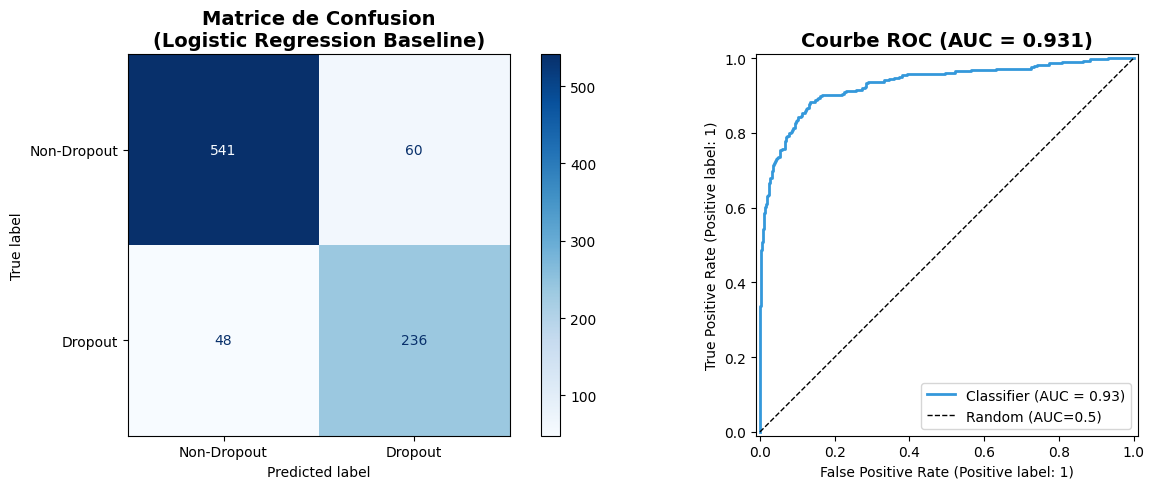


Sur 284 étudiants à risque, le modèle en identifie 236 (83.1%)


In [43]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matrice de confusion
ax1 = axes[0]
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Dropout", "Dropout"])
disp.plot(ax=ax1, cmap="Blues", values_format="d")
ax1.set_title(
    "Matrice de Confusion\n(Logistic Regression Baseline)",
    fontsize=14,
    fontweight="bold",
)

# Courbe ROC
ax2 = axes[1]
RocCurveDisplay.from_predictions(y_test, y_pred_proba, ax=ax2, color="#3498db", lw=2)
ax2.plot([0, 1], [0, 1], "k--", lw=1, label="Random (AUC=0.5)")
ax2.set_title(f"Courbe ROC (AUC = {auc:.3f})", fontsize=14, fontweight="bold")
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Interprétation de la matrice de confusion
tn, fp, fn, tp = cm.ravel()
## Rappel
## Vrai négatifs - TN: Non-dropout correctement identifiés (541)
## Vrai positifs - TP: Dropout correctement identifiés (60)
## Faux positifs - FP: Non-dropout classés Dropout (fausse alerte)
## Faux négatifs - FN: Dropout manqués
print(
    f"\nSur {y_test.sum()} étudiants à risque, le modèle en identifie {tp} ({tp / y_test.sum() * 100:.1f}%)"
)

### Synthèse Phase 6 : Modèle Baseline

**Résultats du modèle Logistic Regression (Baseline)** :

| Métrique | Valeur | Interprétation |
|----------|--------|----------------|
| **Recall (Dropout)** | 83.1% | Sur 284 étudiants à risque, 236 sont identifiés |
| **F1-Score (Dropout)** | 81.4% | Bon équilibre précision/rappel |
| **AUC-ROC** | 93.1% | Excellente capacité de discrimination |
| **Accuracy** | 87.8% | Performance globale |

**Analyse des erreurs** :
- **48 Faux Négatifs** : Étudiants à risque non détectés (**erreur critique**)
- **60 Faux Positifs** : Fausses alertes (coût acceptable)

**Conclusion** :
Le modèle baseline Logistic Regression atteint déjà des performances très satisfaisantes grâce :
1. Aux features engineered (`Success_Rate_Sem2` avec r = -0.705)
2. À la gestion du déséquilibre via `class_weight='balanced'`
3. À un bon prétraitement (StandardScaler + OneHotEncoder)

## Phase 6.2 : Comparaison de Modèles et Optimisation

**Objectif** : Tester plusieurs algorithmes et optimiser le meilleur modèle.

### Modèles à comparer :
| Niveau | Modèle | Caractéristiques |
|--------|--------|------------------|
| Baseline | Logistic Regression | Déjà fait (Recall=83.1%, AUC=93.1%) |
| Intermédiaire | Random Forest | Robuste, feature importance native |
| Intermédiaire | Gradient Boosting | Performant, gère bien le déséquilibre |
| Intermédiaire | SVM (RBF) | Bon pour données non-linéaires |
| Avancé | XGBoost | État de l'art, très performant |

### Stratégie d'évaluation :
- **Cross-validation 5-fold stratifiée** pour comparer équitablement
- **Métrique principale** : F1-Score (équilibre précision/rappel)
- **Métrique secondaire** : Recall (ne pas manquer les dropouts)

### Comparaison de Moèles avec Cross-Validation

In [45]:
# Calculer scale_pos_weight pour XGBoost (ratio classe majoritaire/minoritaire)
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

# Définir les modèles à comparer
models = {
    "Logistic Regression": LogisticRegression(
        class_weight="balanced", max_iter=1000, random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100, class_weight="balanced", random_state=42, n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "SVM (RBF)": SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=100,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric="logloss",
        verbosity=0,
    ),
}

display(list(models.keys()))

['Logistic Regression',
 'Random Forest',
 'Gradient Boosting',
 'SVM (RBF)',
 'XGBoost']

### Cross-validation 5-fold stratifiée
- **Stratification** : préserve les proportions de classes dans chaque fold

In [46]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

records = defaultdict(list)

for name, model in models.items():
    # Créer le pipeline pour chaque modèle
    pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", model)])

    # Calculer les scores
    f1_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="f1", n_jobs=-1)
    recall_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="recall", n_jobs=-1)
    auc_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)

    records['model'].append(name)
    records['f1-mean'].append(f1_scores.mean())
    records['f1-std'].append(f1_scores.std())
    records['recall-mean'].append(recall_scores.mean())
    records['recall-std'].append(recall_scores.std())
    records['auc-mean'].append(auc_scores.mean())
    records['auc-std'].append(auc_scores.std())

results_df = pd.DataFrame(records)

# Trier par F1-Score
results_df = results_df.sort_values("f1-mean", ascending=False)
display(results_df)

,model,f1-mean,f1-std,recall-mean,recall-std,auc-mean,auc-std
3,SVM (RBF),0.789978,0.015374,0.789810,0.019367,0.907778,0.009728
0,Logistic Regression,0.784074,0.021287,0.799490,0.024352,0.913404,0.011958
2,Gradient Boosting,0.783055,0.013038,0.726482,0.012340,0.910512,0.013146
4,XGBoost,0.775949,0.012028,0.758138,0.010677,0.890814,0.009950
1,Random Forest,0.773640,0.018112,0.713278,0.011978,0.906312,0.013044


#### Meilleur modèle

In [47]:
# Identifier le meilleur modèle
best_model_name = results_df.iloc[0]["model"]
best_f1 = results_df.iloc[0]["f1-mean"]
best_recall = results_df.iloc[0]["recall-mean"]

print(f"\nMeilleur modèle (F1-Score) : {best_model_name}")
print(f"   F1 = {best_f1:.3f}, Recall = {best_recall:.3f}")


Meilleur modèle (F1-Score) : SVM (RBF)
   F1 = 0.790, Recall = 0.790


### Visualisation comparative 

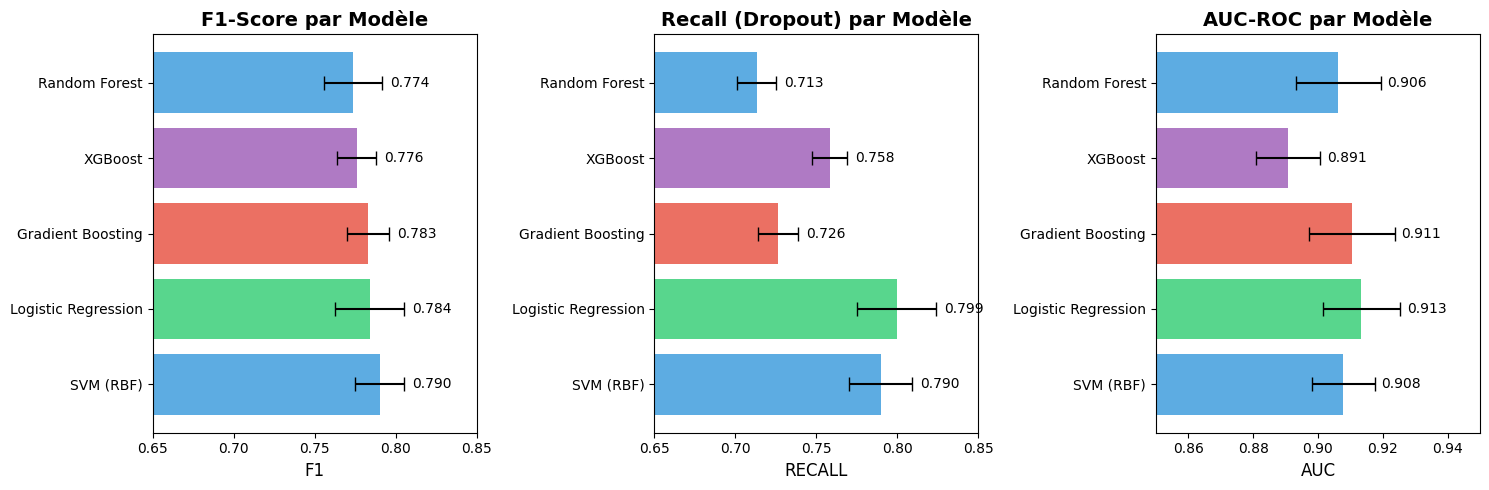


Observation : Les performances sont très proches entre les modèles.
La Logistic Regression a le meilleur Recall (79.9%), important pour détecter les dropouts.


In [48]:
plot_cfg = [
    ("f1",     "F1-Score par Modèle",            (0.65, 0.85), 0.005),
    ("recall", "Recall (Dropout) par Modèle",    (0.65, 0.85), 0.005),
    ("auc",    "AUC-ROC par Modèle",             (0.85, 0.95), 0.002),
]

colors = ["#3498db", "#2ecc71", "#e74c3c", "#9b59b6"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (metric, title, xlim, text_offset) in zip(axes, plot_cfg):
    barh_metric(ax, results_df, metric, title, xlim, text_offset, colors=colors)

plt.tight_layout()
plt.show()

print("\nObservation : Les performances sont très proches entre les modèles.")
print("La Logistic Regression a le meilleur Recall (79.9%), important pour détecter les dropouts.")

### 6.2.5 Optimisation des Hyperparamètres

**Résultats de la comparaison** :
- Les 5 modèles ont des performances très similaires (F1 entre 0.77 et 0.79)
- **Logistic Regression** a le meilleur **Recall** (79.9%) - crucial pour notre objectif
- **SVM (RBF)** a le meilleur **F1-Score** (79.0%)

**Choix** : Nous allons optimiser **Logistic Regression** car :
1. Meilleur Recall (priorité pour détecter les dropouts)
2. Plus interprétable (coefficients analysables)
3. Plus rapide à entraîner et déployer

### GridSearchCV pour la régression logistique

In [49]:
# Grille d'hyperparamètres pour Logistic Regression
param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10, 100],  # Force de régularisation (inverse)
    "classifier__penalty": ["l1", "l2"],  # Type de régularisation
    "classifier__solver": ["saga"],  # Solver compatible avec l1 et l2
    "classifier__class_weight": ["balanced"],  # Gestion du déséquilibre
    "classifier__max_iter": [2000],  # Convergence
}

# Pipeline de base
base_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(random_state=42)),
    ]
)

# GridSearchCV avec F1-Score comme métrique et 5-fold cross-validation
grid_search = GridSearchCV(
    base_pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="f1",
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, y_train)

print("\nMeilleurs hyperparamètres:")
for param, value in grid_search.best_params_.items():
    print(f"- {param.replace('classifier__', '')}: {value}")
print(f"\nMeilleur F1-Score (CV): {grid_search.best_score_:.3f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Meilleurs hyperparamètres:
- C: 1
- class_weight: balanced
- max_iter: 2000
- penalty: l1
- solver: saga

Meilleur F1-Score (CV): 0.785


### Evaluation du modèle optimisé sur le test set

In [50]:
# Le meilleur modèle est déjà réentraîné sur tout le train set
best_model = grid_search.best_estimator_

# Prédictions sur le test set
y_pred_opt = best_model.predict(X_test)
y_pred_proba_opt = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_opt, target_names=["Non-Dropout", "Dropout"]))

# Métriques clés
recall_opt = recall_score(y_test, y_pred_opt)
f1_opt = f1_score(y_test, y_pred_opt)
auc_opt = roc_auc_score(y_test, y_pred_proba_opt)

print("\nMétriques Prioritaires (classe Dropout):")
print(f"- Recall (Dropout)  : {recall_opt:.3f}")
print(f"- F1-Score (Dropout): {f1_opt:.3f}")
print(f"- AUC-ROC           : {auc_opt:.3f}")

# Comparaison avec le baseline
print("\nComparaison avec le Baseline:")
print(f"- Recall    : {recall:.3f} -> {recall_opt:.3f} ({recall_opt - recall:+.1%})")
print(f"- Recall    : {recall:.3f} -> {recall_opt:.3f} ({recall_opt - recall:+.1%})")
print(f"- F1-Score  : {f1:.3f} -> {f1_opt:.3f} ({f1_opt - f1:+.1%})")
print(f"- AUC-ROC   : {auc:.3f} -> {auc_opt:.3f} ({auc_opt - auc:+.1%})")

              precision    recall  f1-score   support

 Non-Dropout       0.92      0.90      0.91       601
     Dropout       0.80      0.83      0.82       284

    accuracy                           0.88       885
   macro avg       0.86      0.87      0.86       885
weighted avg       0.88      0.88      0.88       885


Métriques Prioritaires (classe Dropout):
- Recall (Dropout)  : 0.831
- F1-Score (Dropout): 0.815
- AUC-ROC           : 0.931

Comparaison avec le Baseline:
- Recall    : 0.831 -> 0.831 (+0.0%)
- Recall    : 0.831 -> 0.831 (+0.0%)
- F1-Score  : 0.814 -> 0.815 (+0.1%)
- AUC-ROC   : 0.931 -> 0.931 (-0.0%)


### Visuel final, matrice de confusion et importance des features

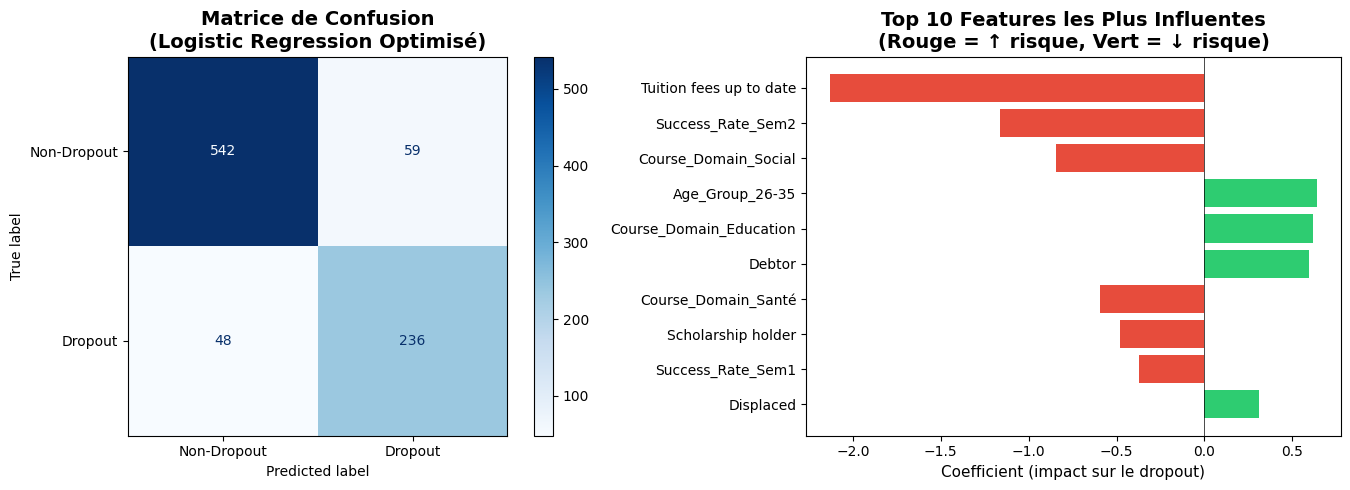


Interprétation des Coefficients:
Coefficient POSITIF → Augmente le risque de dropout
Coefficient NÉGATIF → Diminue le risque de dropout


In [51]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Matrice de confusion du modèle optimisé
ax1 = axes[0]
cm_opt = confusion_matrix(y_test, y_pred_opt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_opt, display_labels=["Non-Dropout", "Dropout"])
disp.plot(ax=ax1, cmap="Blues", values_format="d")
ax1.set_title(
    "Matrice de Confusion\n(Logistic Regression Optimisé)",
    fontsize=14,
    fontweight="bold",
)

# 2. Feature Importance (coefficients absolus)
ax2 = axes[1]

# Extraire les coefficients du modèle
classifier = best_model.named_steps["classifier"]
coefficients = classifier.coef_[0]

# Récupérer les noms des features après transformation
feature_names = (
    numeric_features
    + list(
        best_model.named_steps["preprocessor"]
        .named_transformers_["cat"]
        .get_feature_names_out(categorical_features)
    )
    + binary_features
)

# Créer un DataFrame pour visualisation
coef_df = pd.DataFrame(
    {
        "Feature": feature_names,
        "Coefficient": coefficients,
        "Abs_Coefficient": np.abs(coefficients),
    }
).sort_values("Abs_Coefficient", ascending=True)

# Top 10 features les plus importantes
top_features = coef_df.tail(10)
colors = ["#e74c3c" if c < 0 else "#2ecc71" for c in top_features["Coefficient"]]
ax2.barh(top_features["Feature"], top_features["Coefficient"], color=colors)
ax2.axvline(x=0, color="black", linestyle="-", linewidth=0.5)
ax2.set_xlabel("Coefficient (impact sur le dropout)", fontsize=11)
ax2.set_title(
    "Top 10 Features les Plus Influentes\n(Rouge = ↑ risque, Vert = ↓ risque)",
    fontsize=14,
    fontweight="bold",
)

plt.tight_layout()
plt.show()

# Interprétation
print("\nInterprétation des Coefficients:")
print("Coefficient POSITIF → Augmente le risque de dropout")
print("Coefficient NÉGATIF → Diminue le risque de dropout")

### Synthèse Phase 6.2 : Comparaison et Optimisation

**Résultats de la comparaison (Cross-Validation 5-Fold)** :

| Modèle | F1-Score | Recall | AUC-ROC |
|--------|----------|--------|---------|
| SVM (RBF) | 0.790 ±0.015 | 0.790 ±0.019 | 0.908 ±0.010 |
| Logistic Regression | 0.784 ±0.021 | 0.799 ±0.024 | 0.913 ±0.012 |
| Gradient Boosting | 0.783 ±0.013 | 0.726 ±0.012 | 0.911 ±0.013 |
| XGBoost | 0.776 ±0.012 | 0.758 ±0.011 | 0.891 ±0.010 |
| Random Forest | 0.774 ±0.018 | 0.713 ±0.012 | 0.906 ±0.013 |

**Choix et Optimisation** :
- Modèle choisi : **Logistic Regression** (meilleur Recall, interprétable)
- Hyperparamètres optimaux : `C=1`, `penalty='l1'`, `solver='saga'`

**Résultats du modèle optimisé (Test Set)** :

| Métrique | Baseline | Optimisé | Changement |
|----------|----------|----------|------------|
| Recall (Dropout) | 83.1% | 83.1% | +0.0% |
| F1-Score (Dropout) | 81.4% | 81.5% | +0.1% |
| AUC-ROC | 93.1% | 93.1% | +0.0% |

**Conclusion** :
1. Les 5 modèles testés ont des performances très similaires
2. L'optimisation des hyperparamètres n'a pas significativement amélioré les résultats
3. Cela confirme que les **features engineered** sont le facteur clé de la performance
4. Le modèle baseline était déjà proche de l'optimal grâce à l'EDA de qualité

**Top 5 Features les plus importantes** (Logistic Regression avec L1) :
1. `Success_Rate_Sem2` - Taux de réussite 2ème semestre
2. `Success_Rate_Sem1` - Taux de réussite 1er semestre
3. `Tuition fees up to date` - Frais de scolarité à jour
4. `Age_Group_36+` - Étudiants de 36 ans et plus
5. `Avg_Grade` - Moyenne des notes